# ML Exercise 1 - Breast Cancer

### Experiment design

1. Exploration:
    - Target Distribution
    - Missing Values distribution
    - Outliers
2. Preprocessing:
    - Split Train/Test (70-30)
    - Clean missing values
    - Remove outliers
    - Scaling
    - Encoding
    - PCA
3. Models:
    - KNN
    - RF
    - MLP
4. Hyperparameter optimization (Randomized Search CV)
    - Performance comparison
    - Holdout
    - Cross-validation
5. Metrics:
    - Accuracy
    - Precision
    - Recall
    - F1-Score
    - Runtime comparison

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import warnings
import time

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 1. Exploratory Data Analysis

As this is the data from the competition, it is already divided into a train and test split. The data is divided into a roughly 50-50 split. In the training data we have a distribution of the target variable of: False - 176 (62%), True - 109 (38%). 

In [2]:
df = pd.read_csv("data/breast-cancer-diagnostic.shuf.lrn.csv")

In [3]:
df['class'].value_counts()

False    176
True     109
Name: class, dtype: int64

In [4]:
df.shape

(285, 32)

In [5]:
df.head()

,ID,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,fractalDimensionMean,radiusStdErr,textureStdErr,perimeterStdErr,areaStdErr,smoothnessStdErr,compactnessStdErr,concavityStdErr,concavePointsStdErr,symmetryStdErr,fractalDimensionStdErr,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,8611161,False,13.34,15.86,86.49,520.0,0.10780,0.1535,0.11690,0.06987,0.1942,0.06902,0.2860,1.0160,1.535,12.96,0.006794,0.03575,0.03980,0.01383,0.02134,0.004603,15.53,23.19,96.66,614.9,0.1536,0.4791,0.4858,0.17080,0.3527,0.10160
1,8912280,True,16.24,18.77,108.80,805.1,0.10660,0.1802,0.19480,0.09052,0.1876,0.06684,0.2873,0.9173,2.464,28.09,0.004563,0.03481,0.03872,0.01209,0.01388,0.004081,18.55,25.09,126.90,1031.0,0.1365,0.4706,0.5026,0.17320,0.2770,0.10630
2,901303,False,16.17,16.07,106.30,788.5,0.09880,0.1438,0.06651,0.05397,0.1990,0.06572,0.1745,0.4890,1.349,14.91,0.004510,0.01812,0.01951,0.01196,0.01934,0.003696,16.97,19.14,113.10,861.5,0.1235,0.2550,0.2114,0.12510,0.3153,0.08960
3,86973701,False,14.95,18.77,97.84,689.5,0.08138,0.1167,0.09050,0.03562,0.1744,0.06493,0.4220,1.9090,3.271,39.43,0.005790,0.04877,0.05303,0.01527,0.03356,0.009368,16.25,25.47,107.10,809.7,0.0997,0.2521,0.2500,0.08405,0.2852,0.09218
4,8511133,True,15.34,14.26,102.50,704.4,0.10730,0.2135,0.20770,0.09756,0.2521,0.07032,0.4388,0.7096,3.384,44.91,0.006789,0.05328,0.06446,0.02252,0.03672,0.004394,18.07,19.08,125.10,980.9,0.1390,0.5954,0.6305,0.23930,0.4667,0.09946


In [6]:
# there are no duplicate ID's
df.ID[df.reset_index().ID.duplicated()]

Series([], Name: ID, dtype: int64)

### 1.1. Target distribution  
In the training data set that we will use to train and tune our models, we have a target distribution of:  

True - 109 (38%)  
False - 176 (62%)

### 1.2. Missing values  
We have no missing values in this data set.

In [7]:
# We have no missing values
df.isna().sum()

ID                         0
class                      0
radiusMean                 0
 textureMean               0
 perimeterMean             0
 areaMean                  0
 smoothnessMean            0
 compactnessMean           0
 concavityMean             0
 concavePointsMean         0
 symmetryMean              0
 fractalDimensionMean      0
 radiusStdErr              0
 textureStdErr             0
 perimeterStdErr           0
 areaStdErr                0
 smoothnessStdErr          0
 compactnessStdErr         0
 concavityStdErr           0
 concavePointsStdErr       0
 symmetryStdErr            0
 fractalDimensionStdErr    0
 radiusWorst               0
 textureWorst              0
 perimeterWorst            0
 areaWorst                 0
 smoothnessWorst           0
 compactnessWorst          0
 concavityWorst            0
 concavePointsWorst        0
 symmetryWorst             0
 fractalDimensionWorst     0
dtype: int64

<AxesSubplot:>

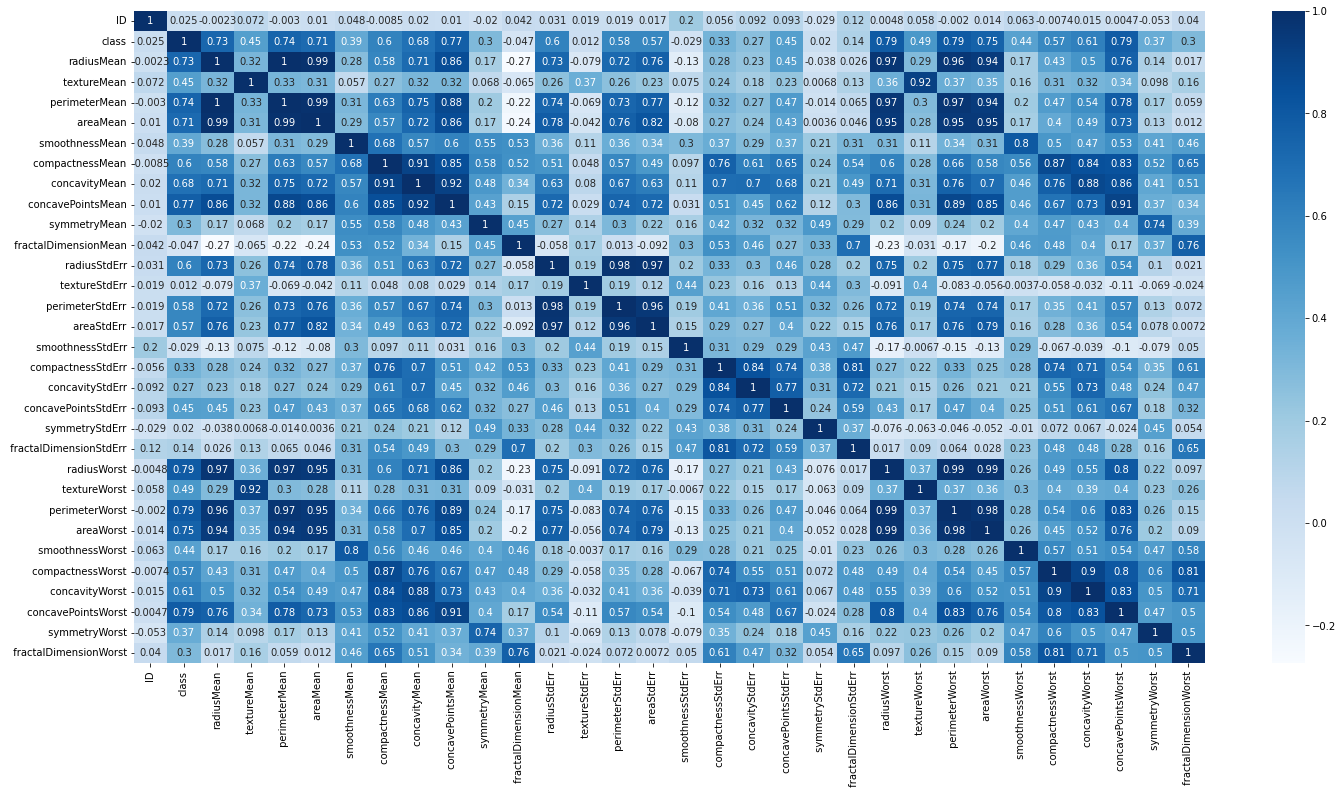

In [8]:
# a lot of variables are correlated between each other, as well as with the target variable which 
# makes sense considering all of the attributes are hearth measures
plt.figure(figsize=(24,12))
sns.heatmap(df.corr(),cbar=True,annot=True,cmap='Blues')

In [9]:
df.describe()

,ID,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,fractalDimensionMean,radiusStdErr,textureStdErr,perimeterStdErr,areaStdErr,smoothnessStdErr,compactnessStdErr,concavityStdErr,concavePointsStdErr,symmetryStdErr,fractalDimensionStdErr,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
count,2.850000e+02,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,3.191306e+07,14.272789,19.544526,92.963474,668.838246,0.096242,0.104109,0.091194,0.049649,0.181722,0.062482,0.401671,1.250156,2.866316,40.768102,0.006969,0.025196,0.031928,0.011503,0.020817,0.003673,16.465407,26.266000,108.698035,901.727018,0.132353,0.258691,0.279750,0.116433,0.293109,0.083869
std,1.294778e+08,3.586806,4.540402,24.891629,360.156618,0.013242,0.053756,0.084430,0.040514,0.026301,0.006383,0.283955,0.553733,2.101688,46.085362,0.003100,0.018242,0.029893,0.005726,0.008992,0.002234,4.925841,6.454098,34.482750,574.910315,0.021376,0.164465,0.220628,0.066483,0.061522,0.018157
min,8.670000e+03,6.981000,10.380000,43.790000,143.500000,0.064290,0.023440,0.000000,0.000000,0.122000,0.050250,0.111500,0.360200,0.771400,7.228000,0.001713,0.003710,0.000000,0.000000,0.009947,0.000950,7.930000,12.870000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.160300,0.055250
25%,8.712010e+05,11.740000,16.390000,75.510000,421.000000,0.086710,0.063740,0.029580,0.020080,0.162000,0.058260,0.231500,0.894400,1.565000,17.610000,0.005043,0.013400,0.015140,0.007591,0.015180,0.002211,13.060000,21.510000,84.350000,520.500000,0.117200,0.151600,0.120100,0.065750,0.254900,0.071270
50%,9.062900e+05,13.500000,19.070000,87.210000,566.200000,0.095860,0.092280,0.065920,0.034000,0.180000,0.061130,0.307700,1.178000,2.222000,23.350000,0.006298,0.020420,0.025260,0.010830,0.018790,0.003114,15.090000,25.780000,98.370000,694.400000,0.133200,0.209600,0.229800,0.099930,0.284100,0.079530
75%,8.810528e+06,16.170000,21.880000,106.200000,809.800000,0.105300,0.129200,0.132300,0.075070,0.195600,0.065760,0.483400,1.503000,3.399000,48.310000,0.008045,0.030840,0.039960,0.014660,0.022930,0.004476,19.260000,30.700000,128.500000,1156.000000,0.144400,0.342000,0.379100,0.162500,0.318700,0.092180
max,9.113205e+08,28.110000,39.280000,188.500000,2499.000000,0.144700,0.345400,0.426800,0.201200,0.290600,0.084500,2.873000,4.885000,21.980000,525.600000,0.031130,0.135400,0.303800,0.039270,0.078950,0.017920,33.130000,49.540000,229.300000,3432.000000,0.222600,1.058000,1.252000,0.291000,0.577400,0.207500


In [10]:
# remove leading and trailing whitespace in column names
df = df.rename(columns=lambda x: x.strip())

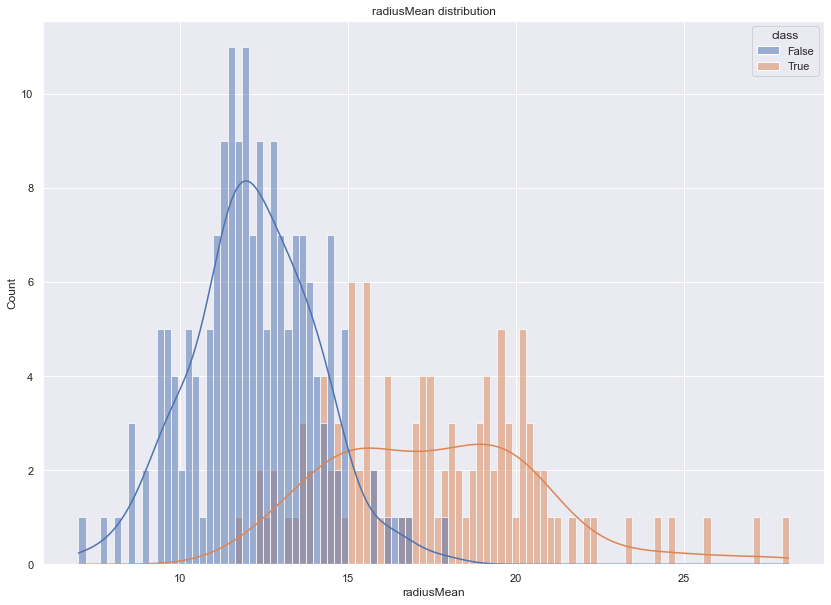

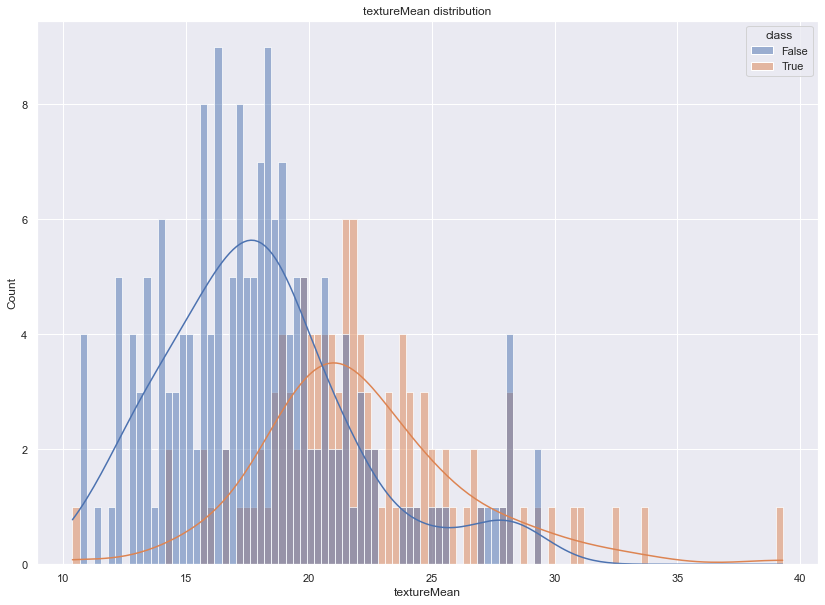

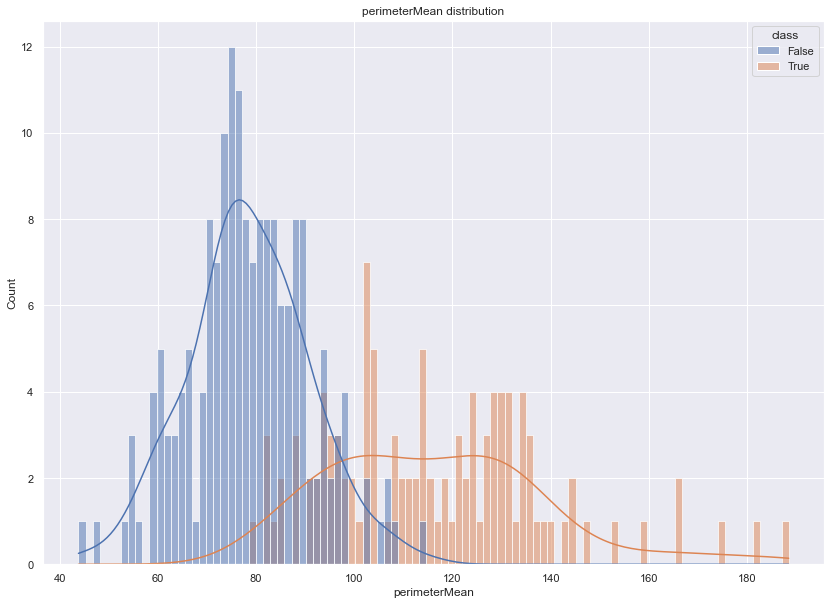

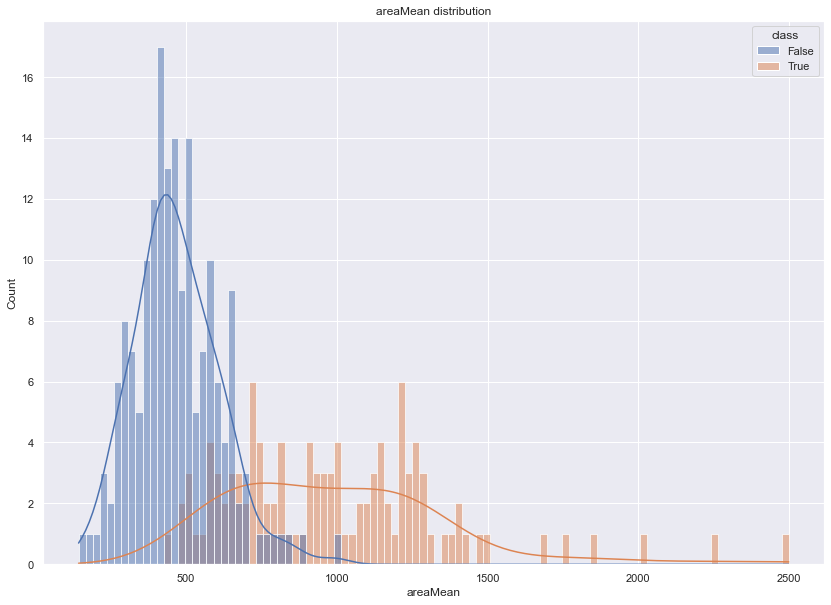

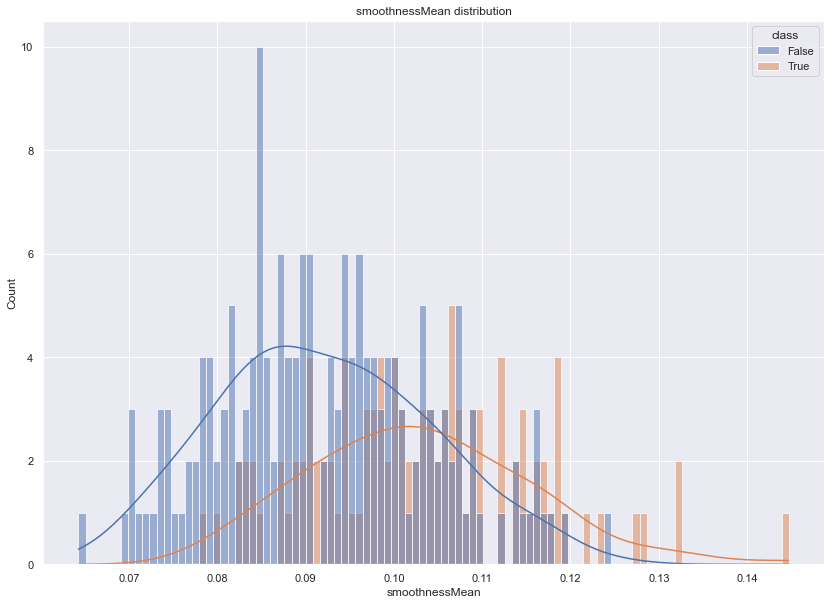

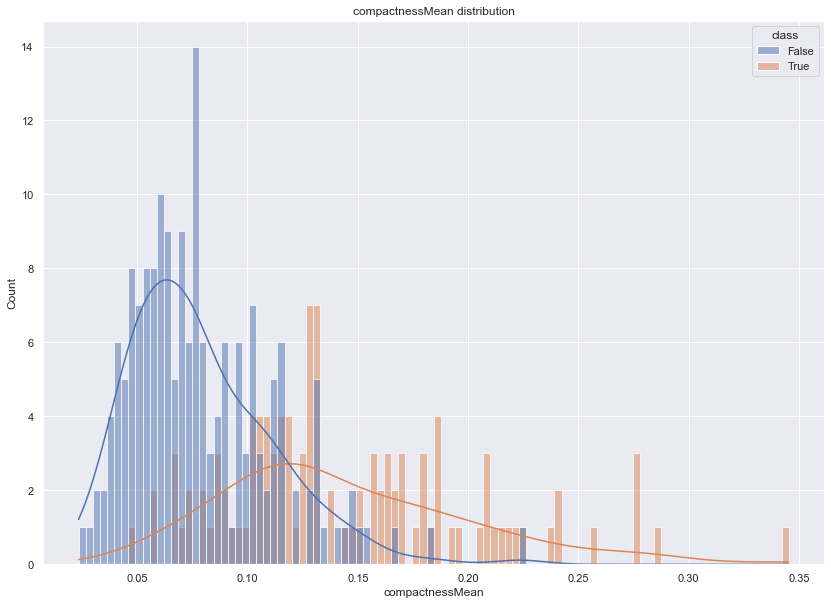

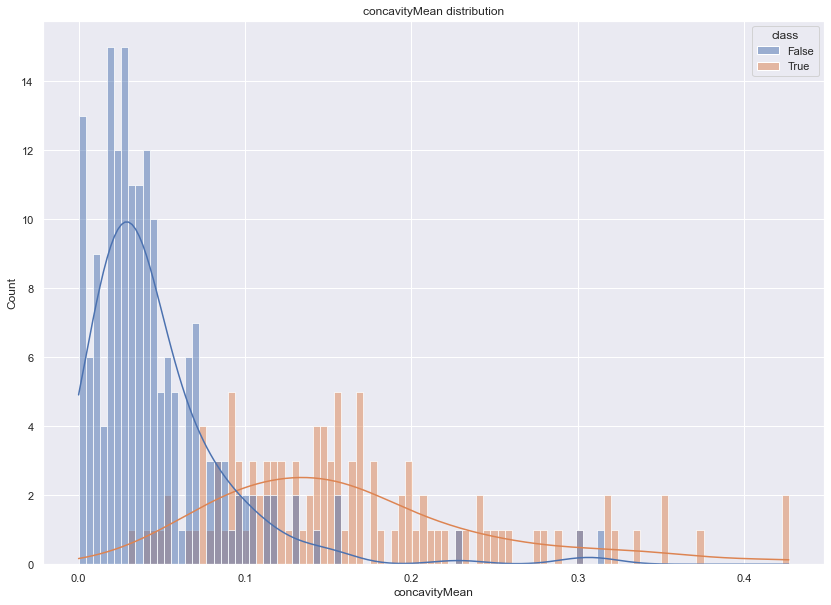

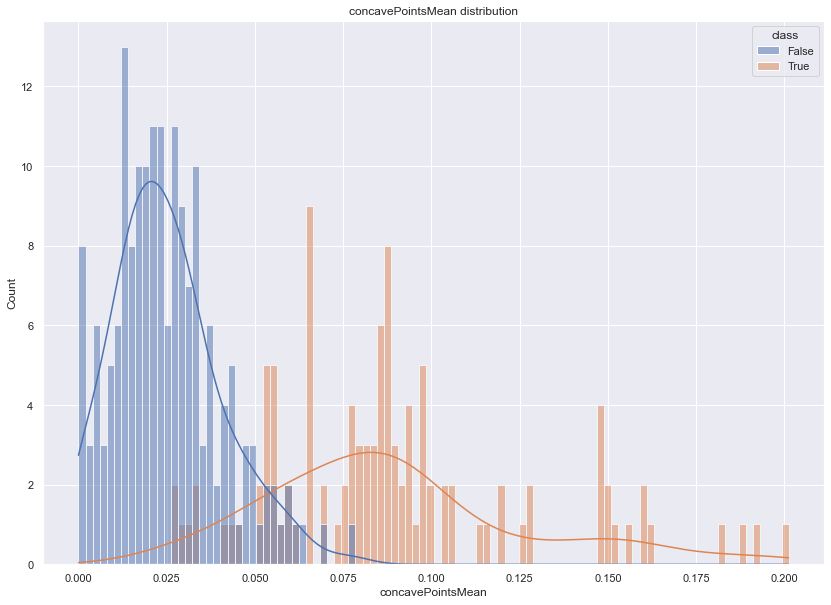

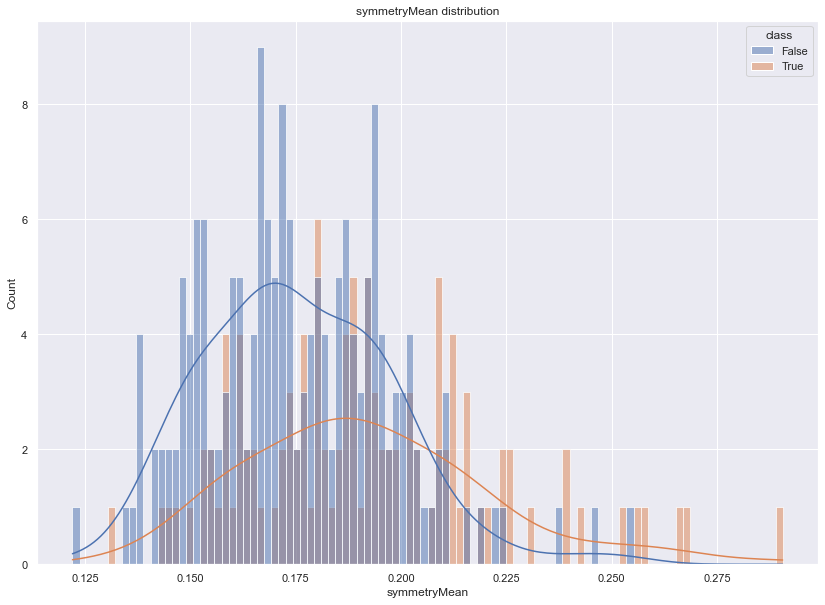

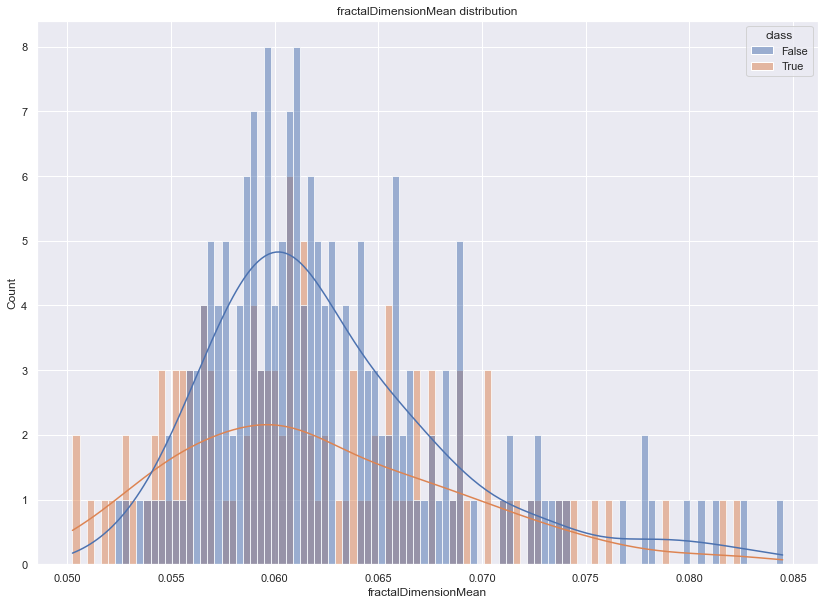

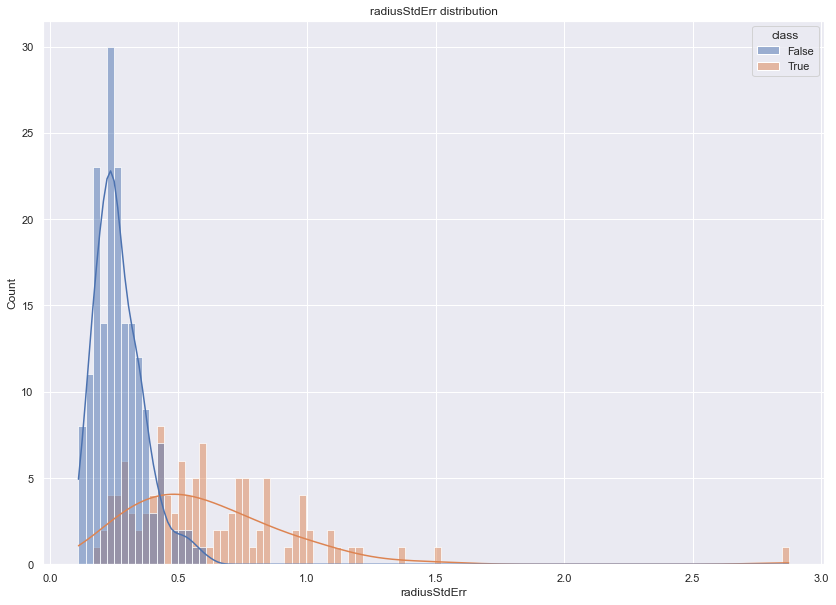

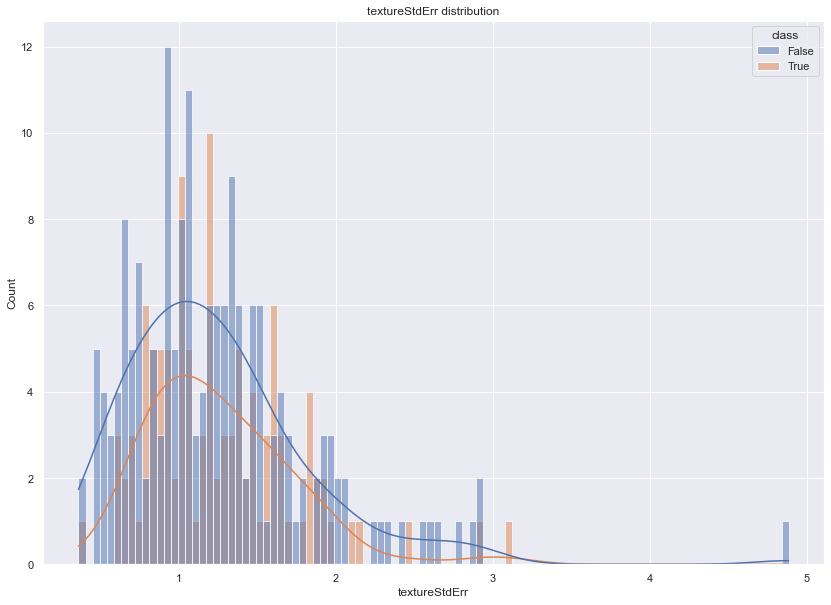

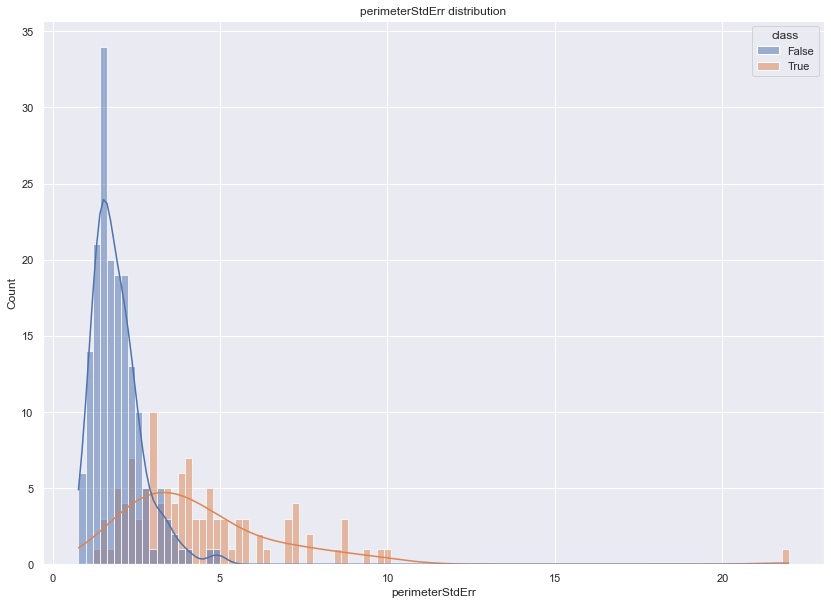

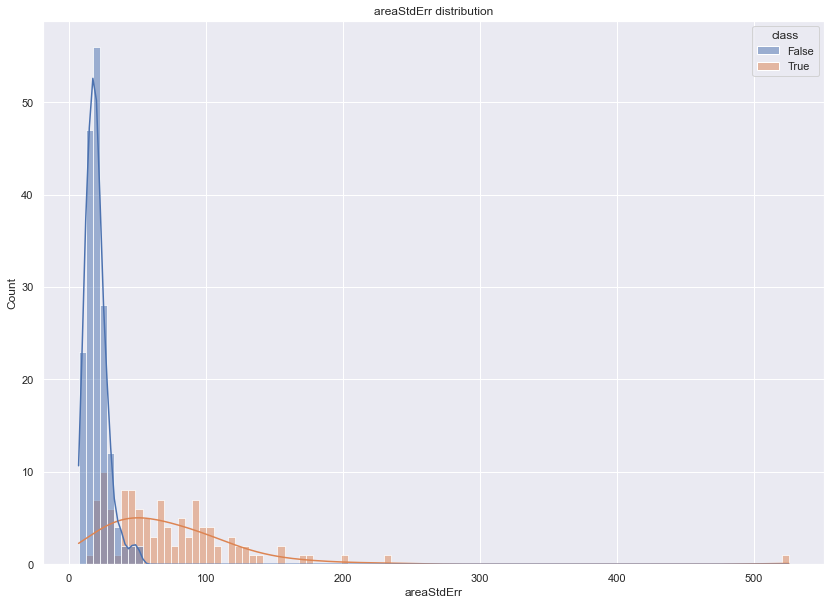

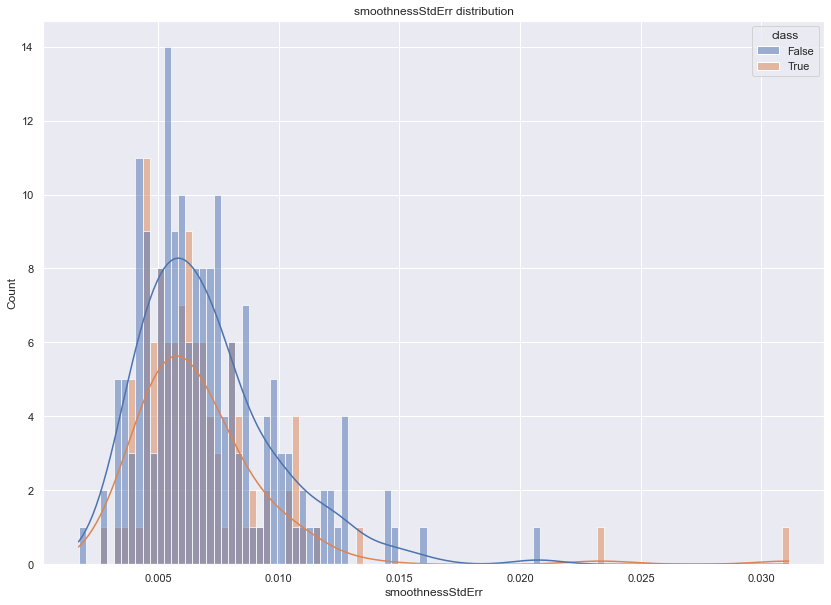

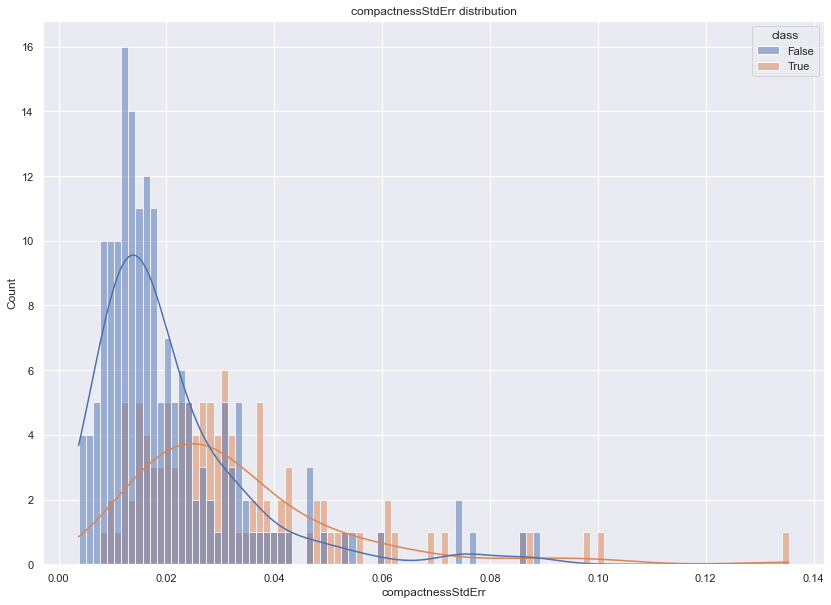

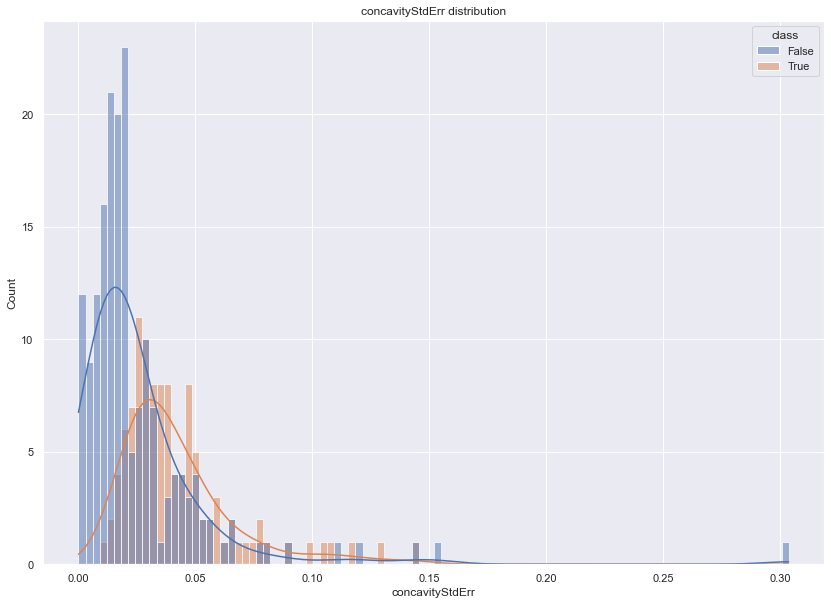

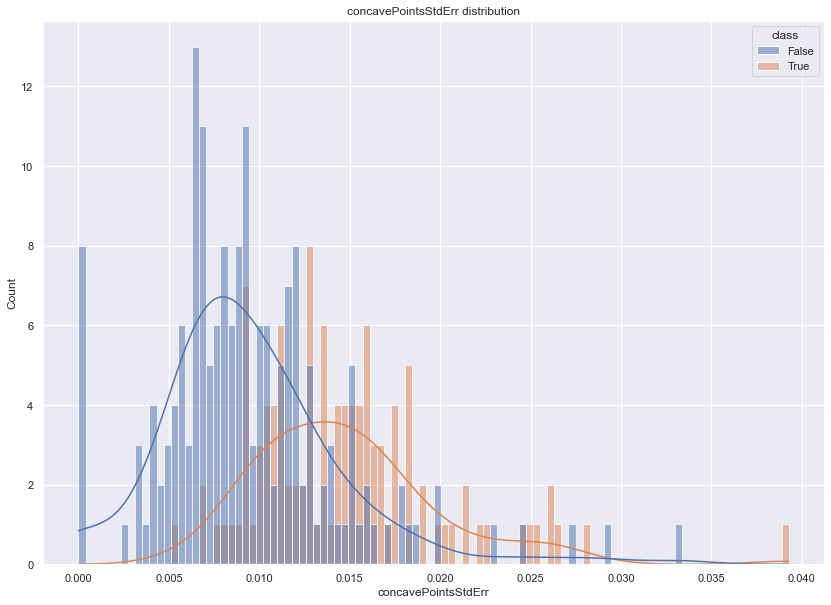

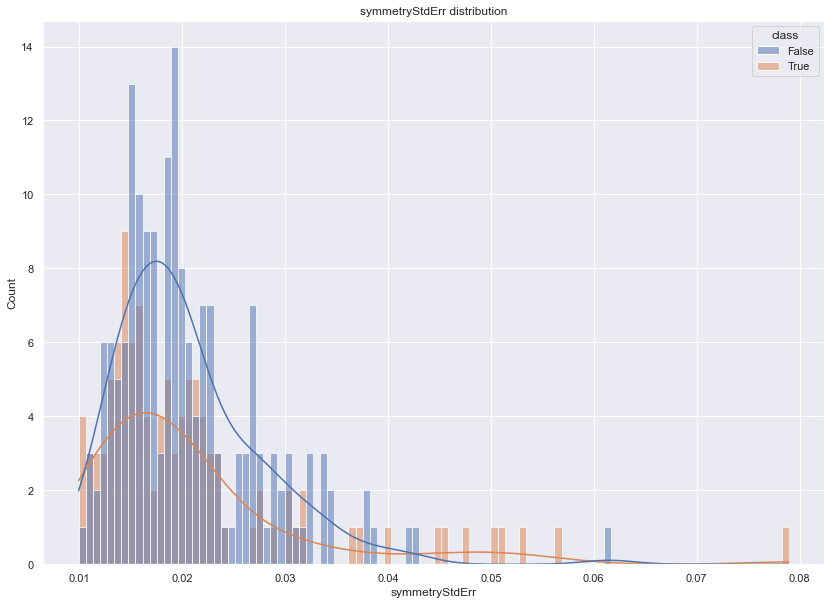

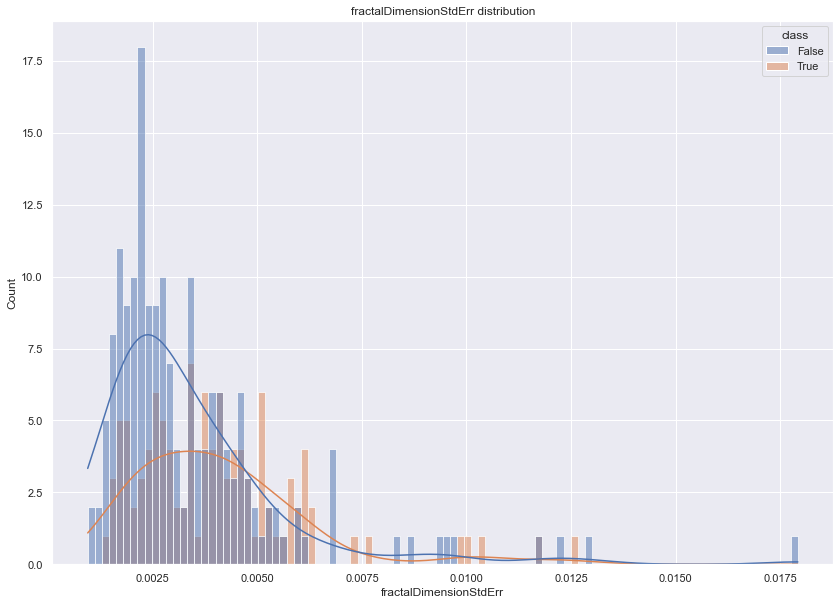

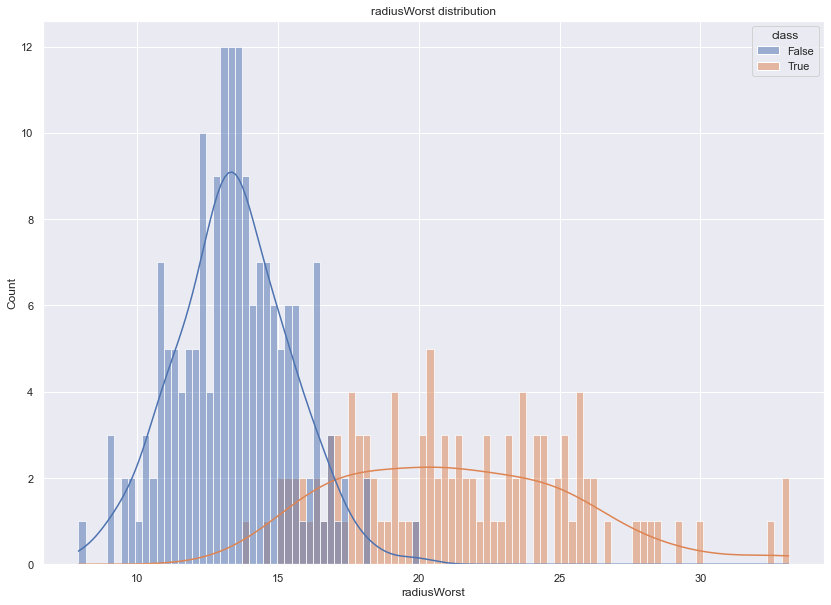

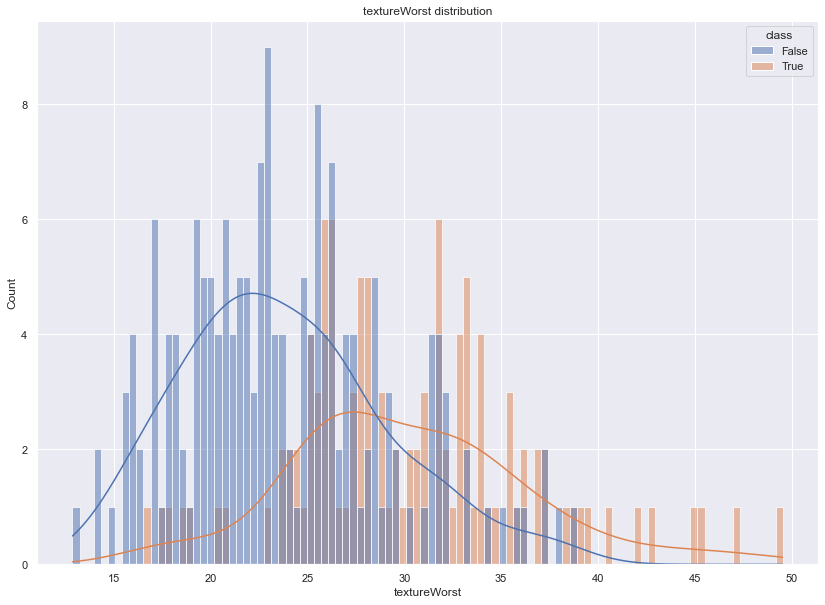

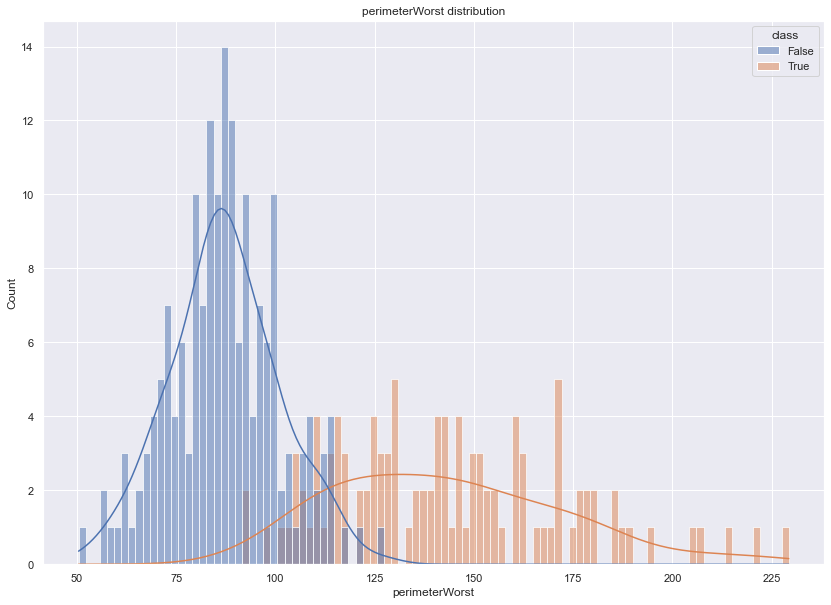

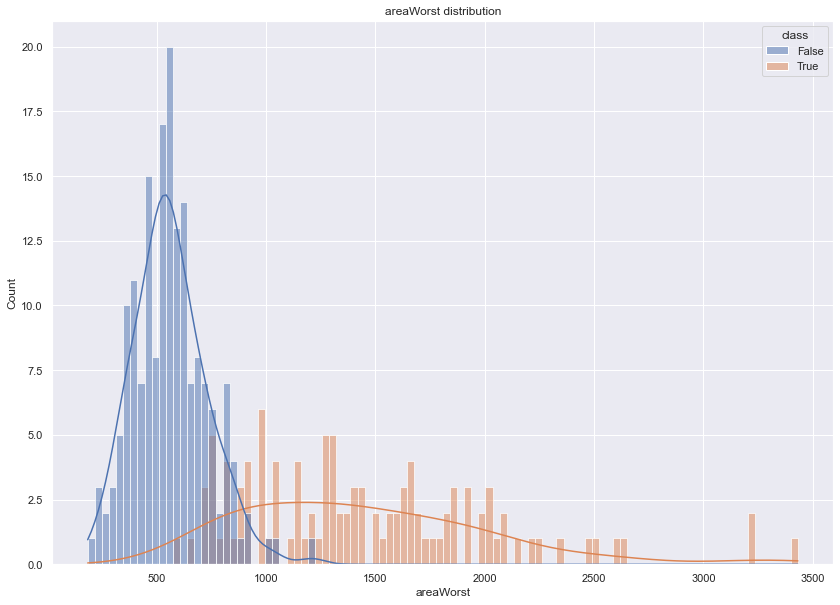

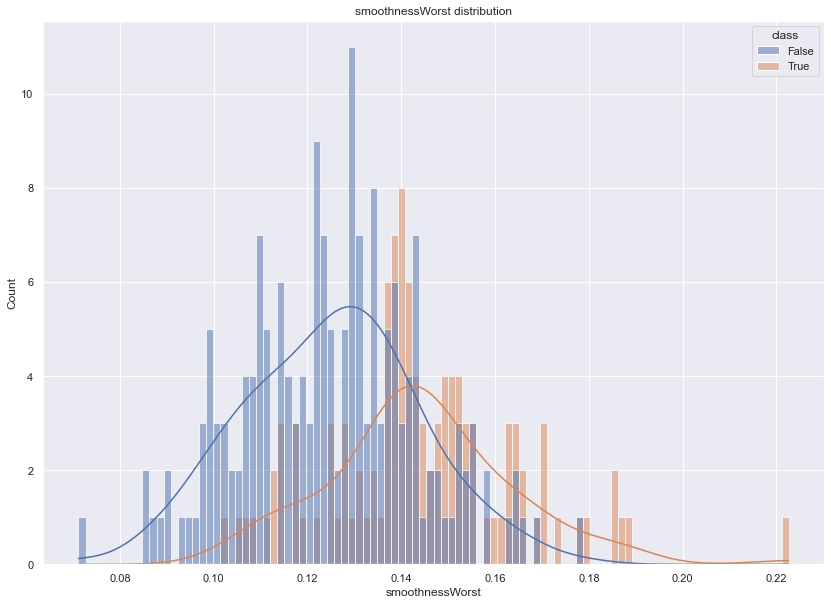

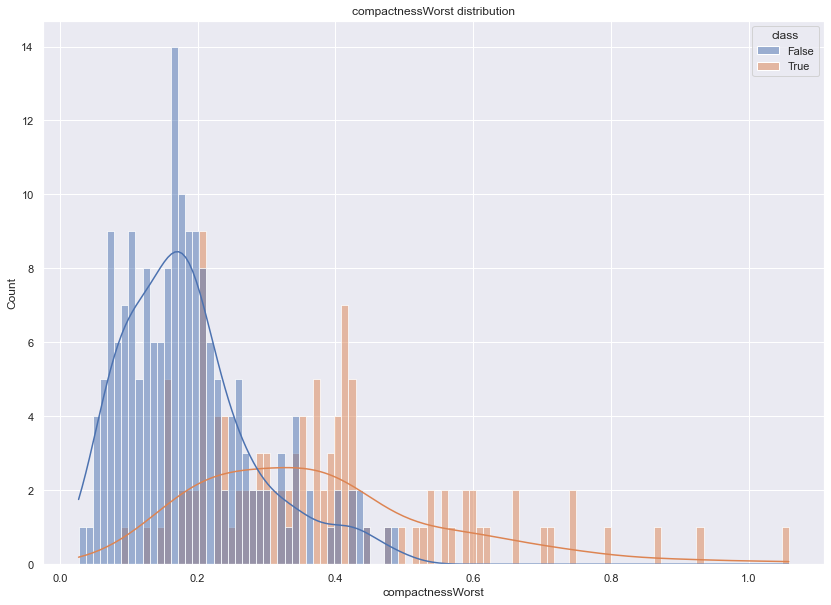

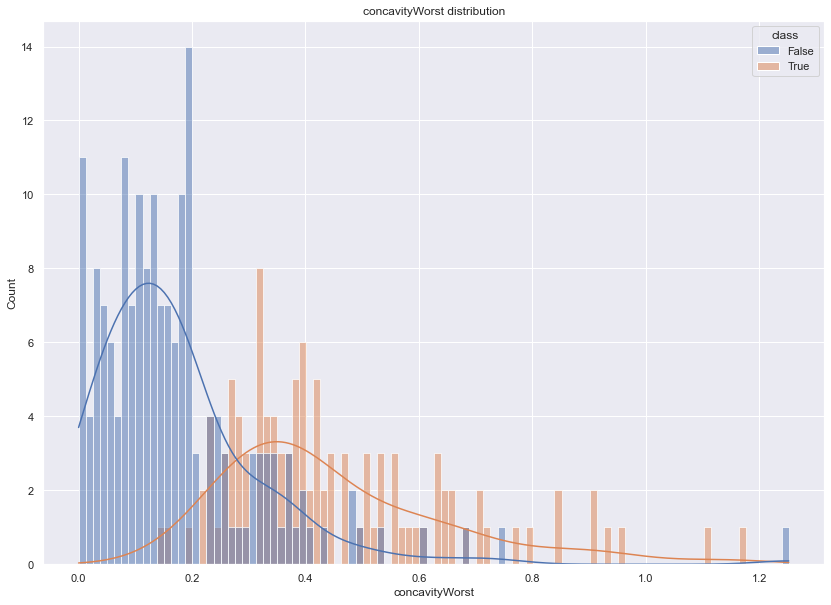

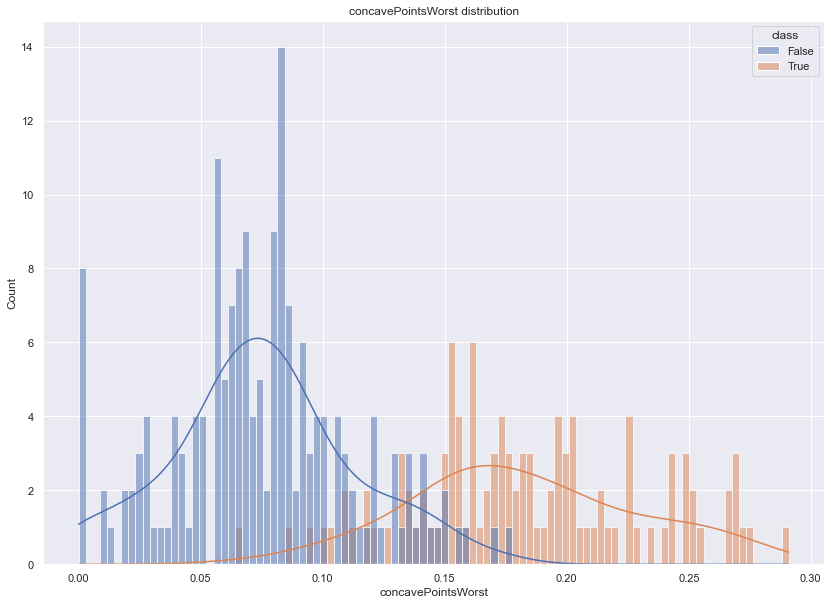

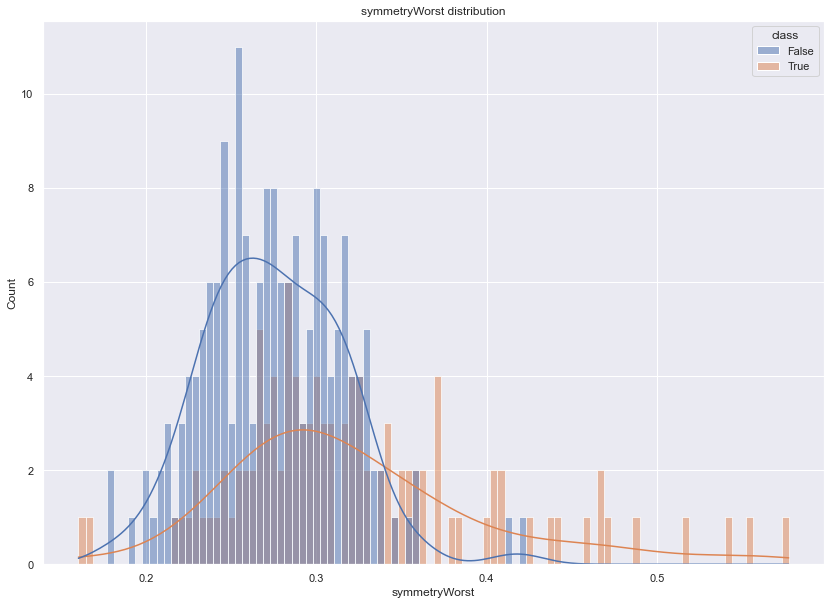

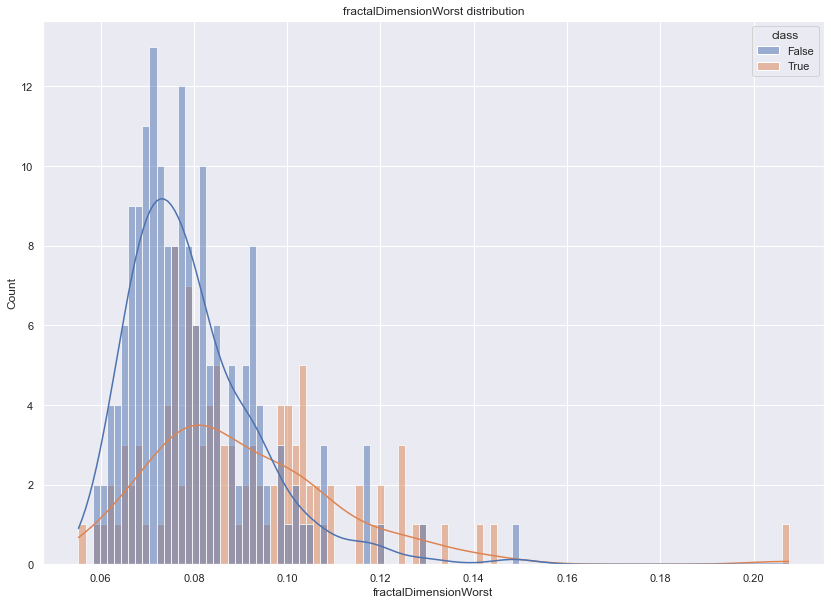

In [11]:
# plotting the distributions of the variables, with regards to the target variable
sns.set(rc={'figure.figsize':(14,10)})
plt.rcParams.update({'figure.max_open_warning': 0})

for i, col in enumerate(df.columns[2:]):
    plt.figure(i)
    plt.title(col+" distribution")
    sns.histplot(x=col, data=df, bins=100, hue="class", kde=True)

### Distribution of independent variables

The distribution of the independent variables fluctuates between positive and negative classes as expected. We can see in almost all attributes that the positive observations have higher/bigger measures than negative. That is because bigger heart generally speaking is not healthy. It is a sign that the heart is having trouble pumping blood efficiently, and that there is an issue with the patient's cardiovascular system. There are some attributes like smoothnes and texture that have measures a bit more similar between the classes.

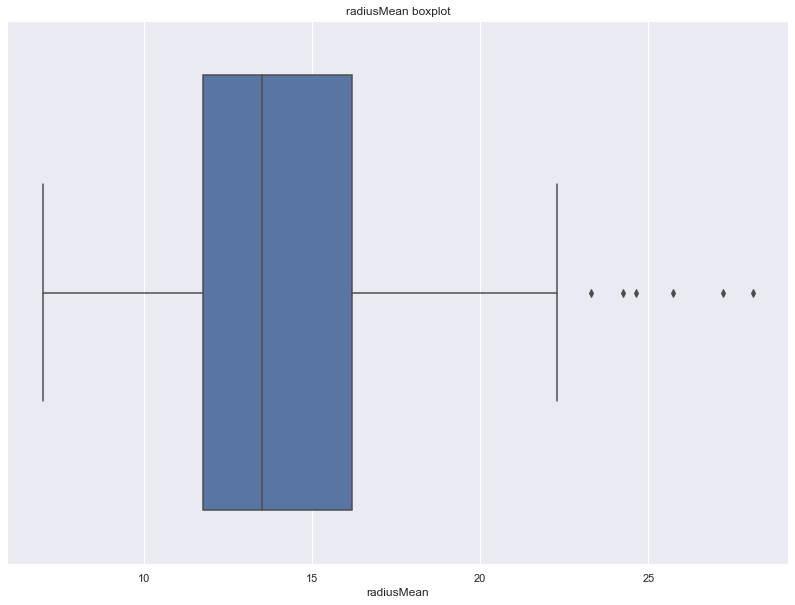

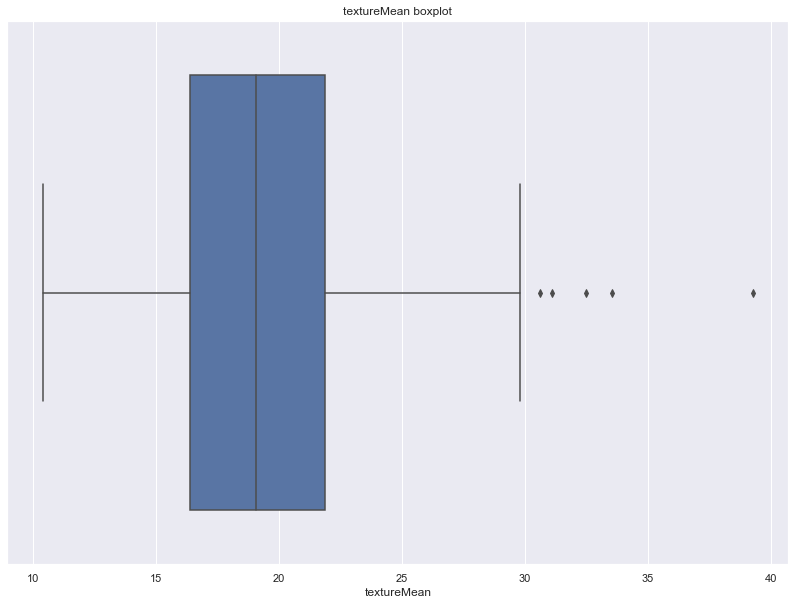

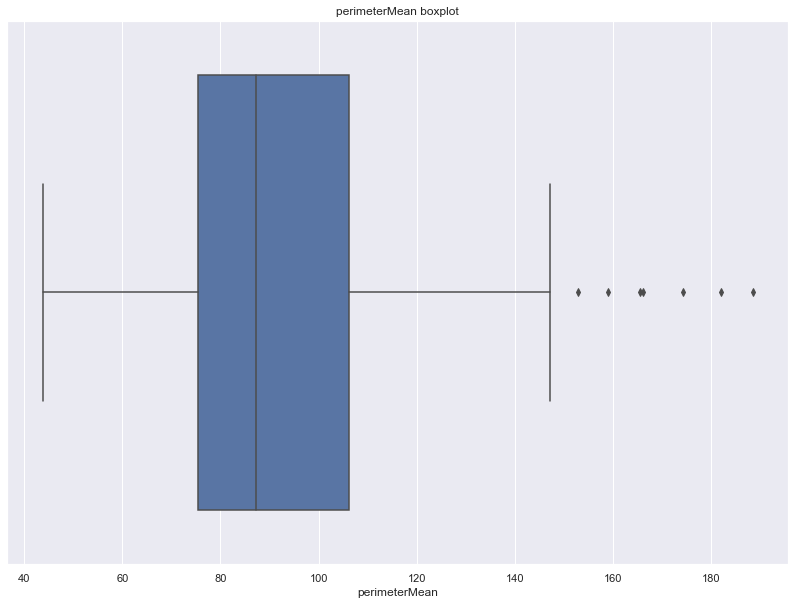

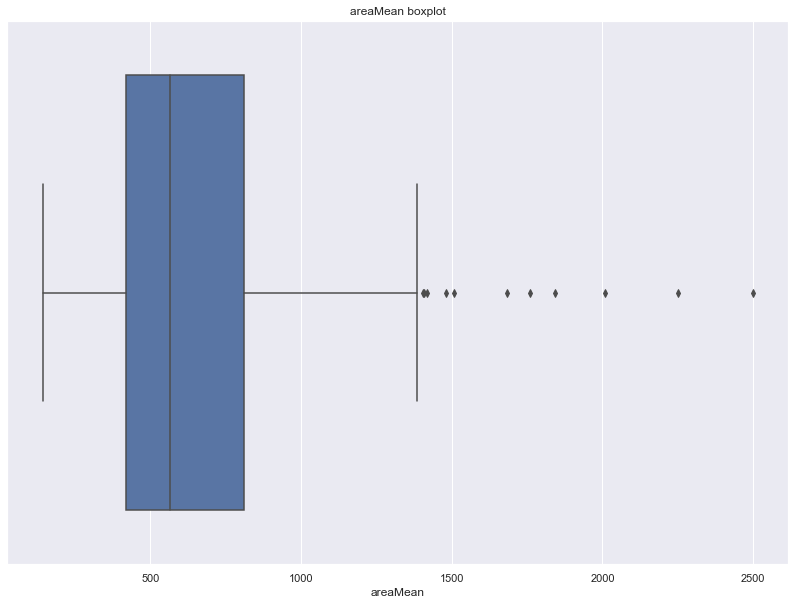

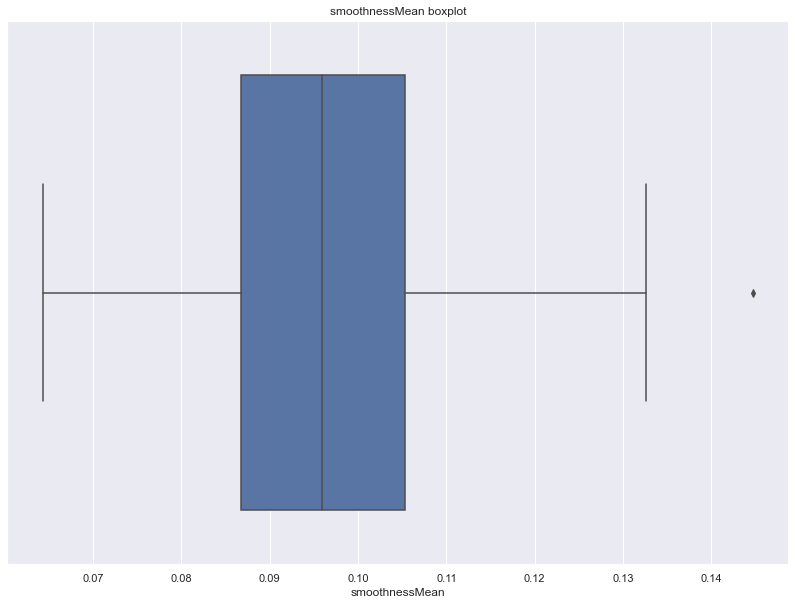

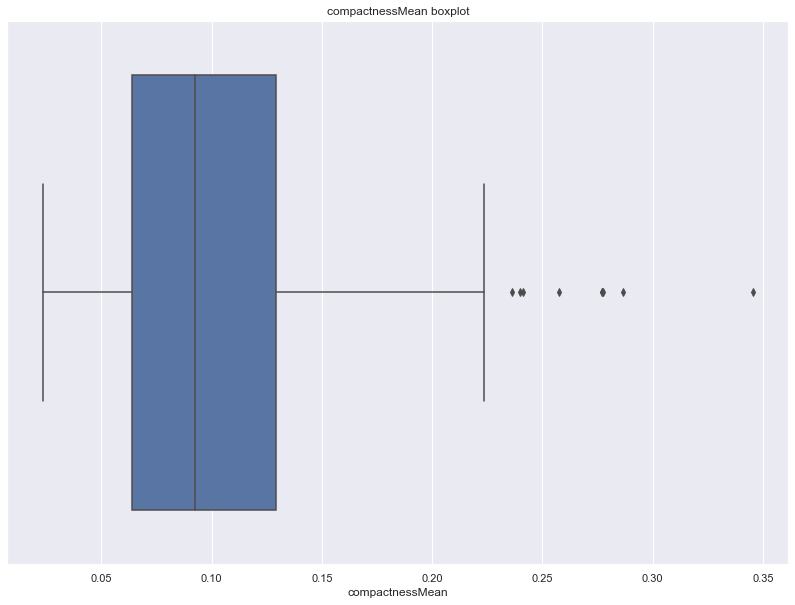

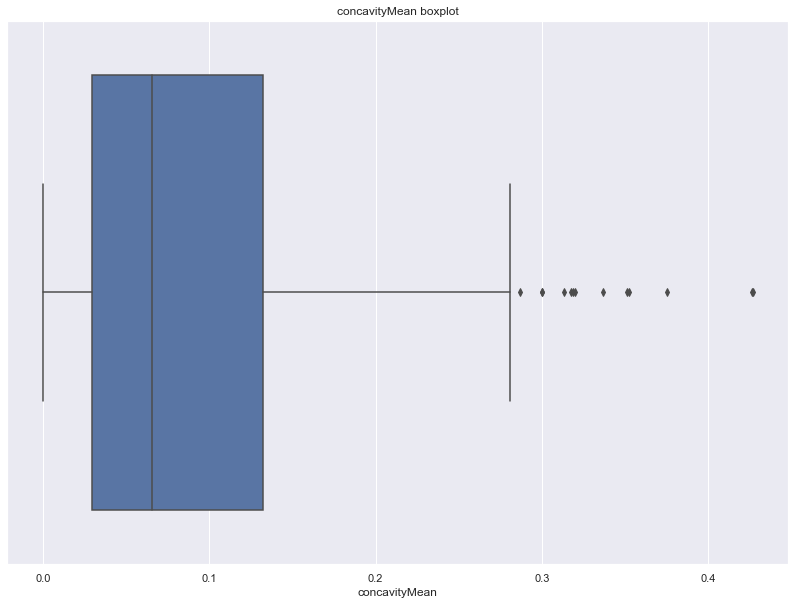

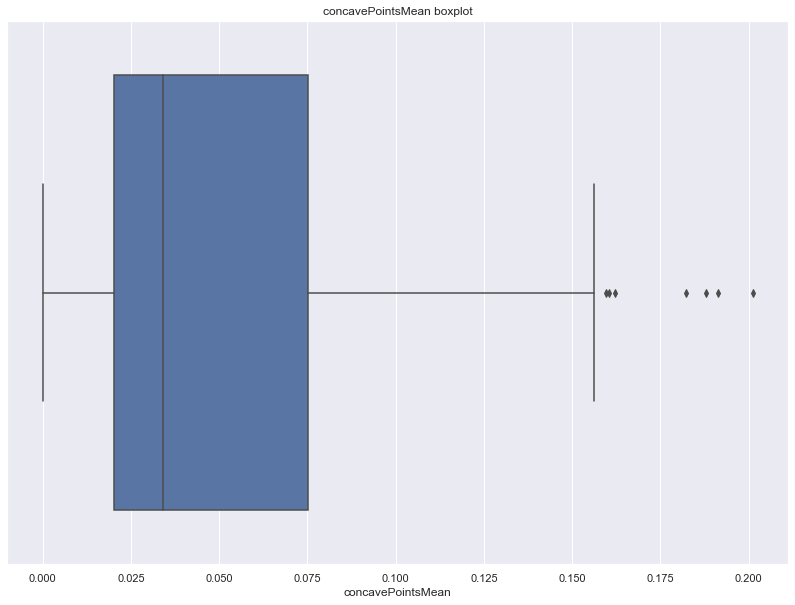

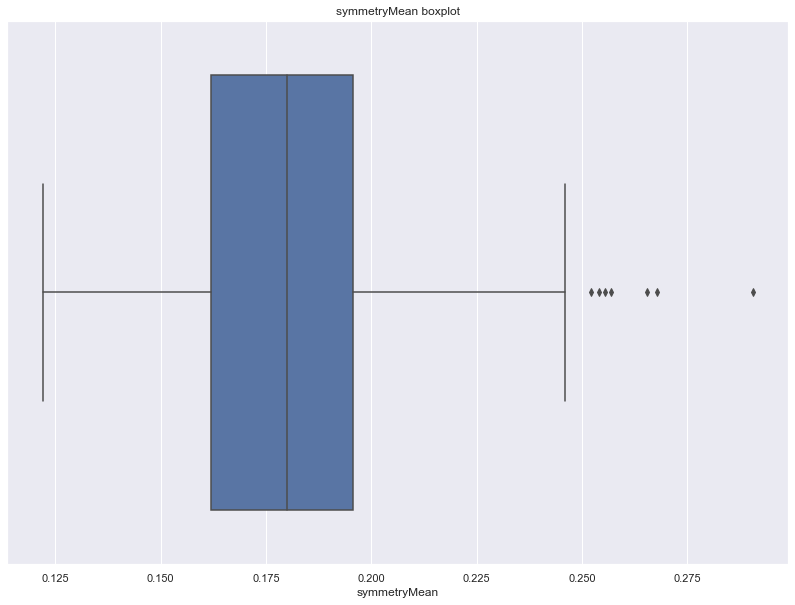

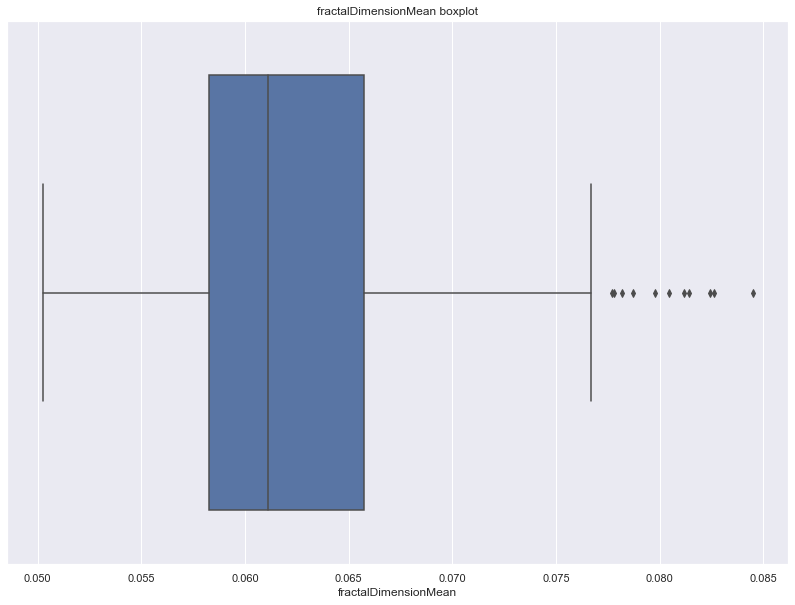

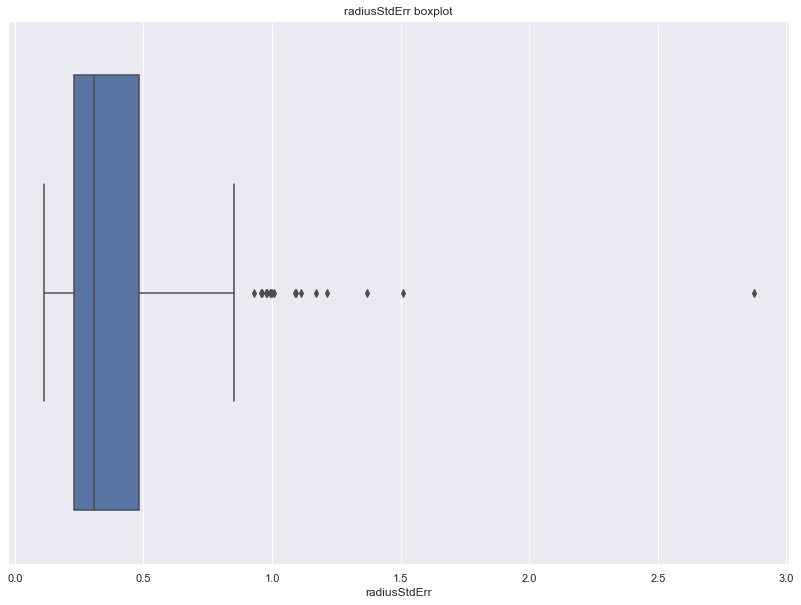

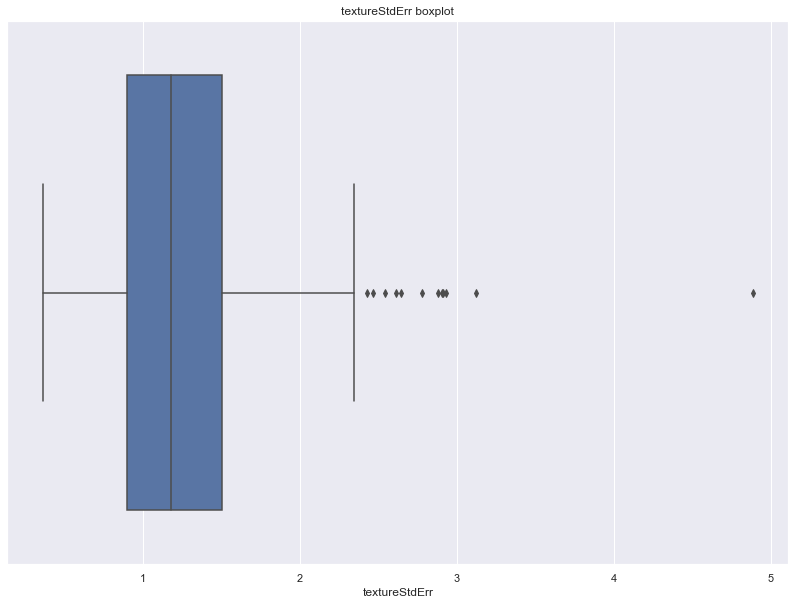

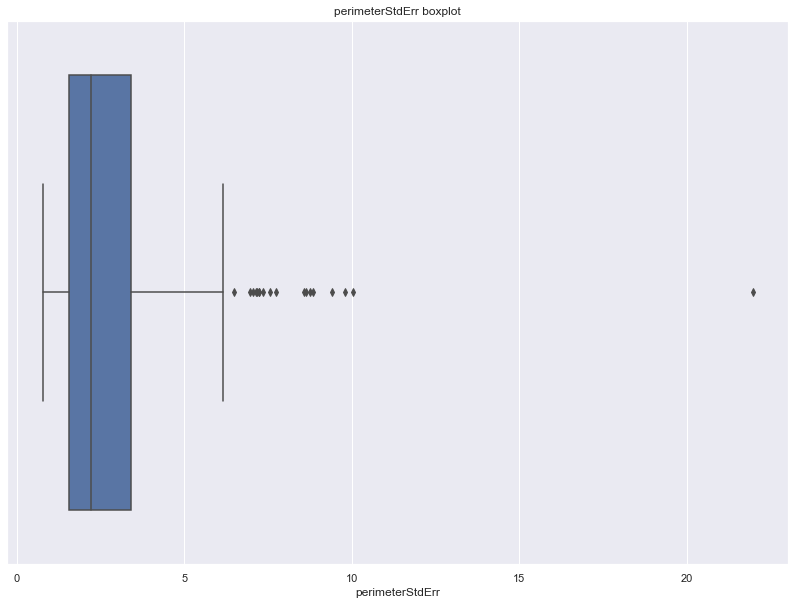

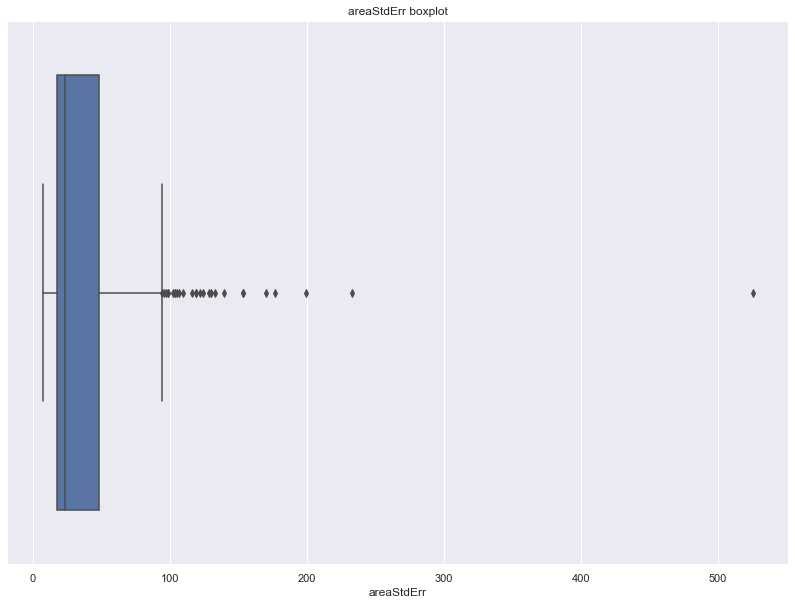

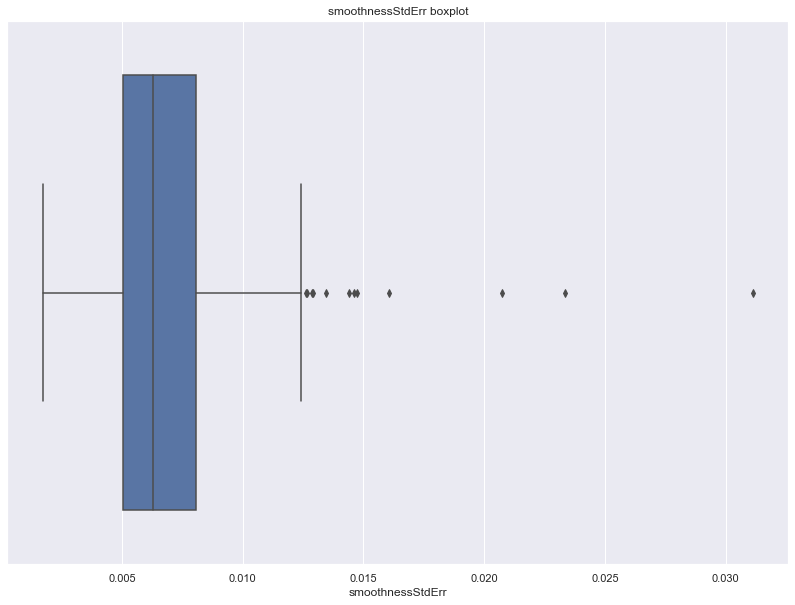

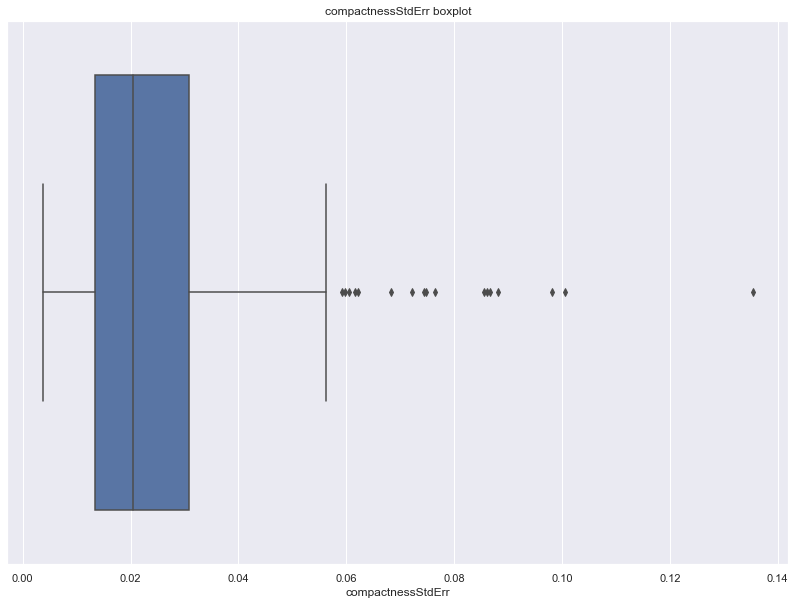

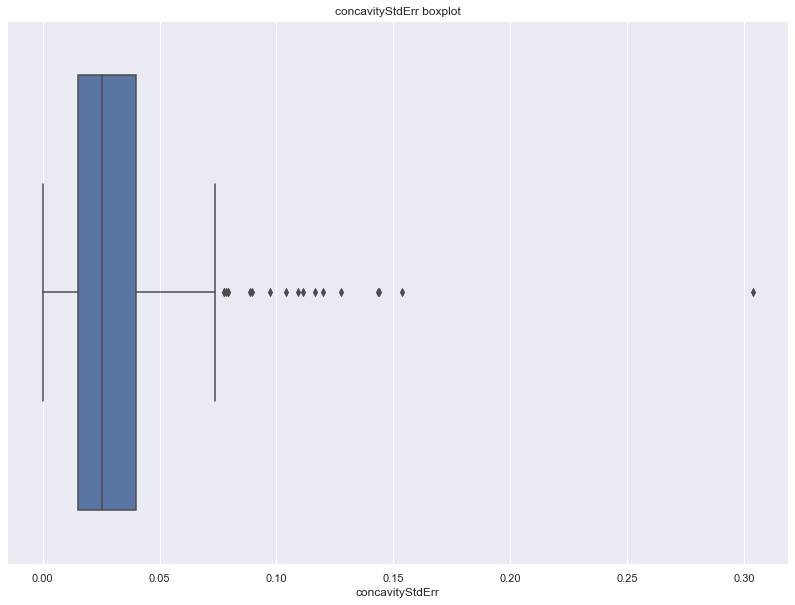

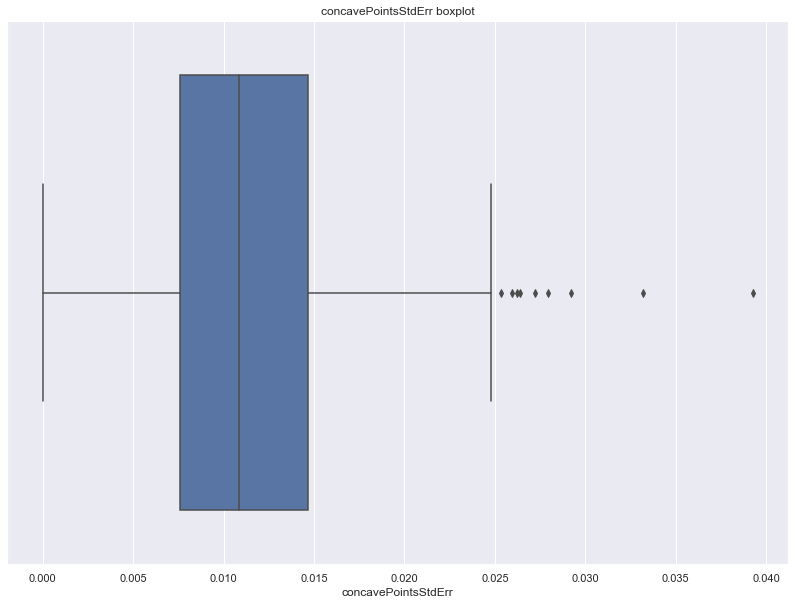

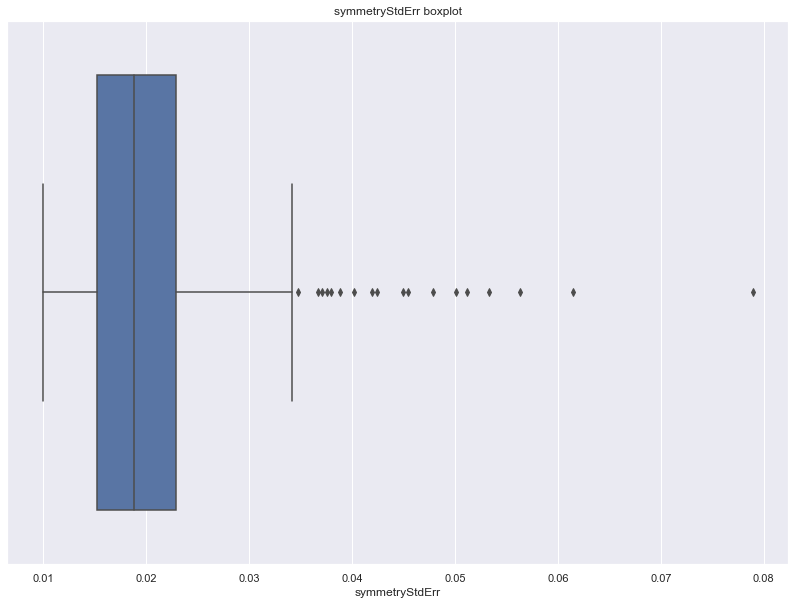

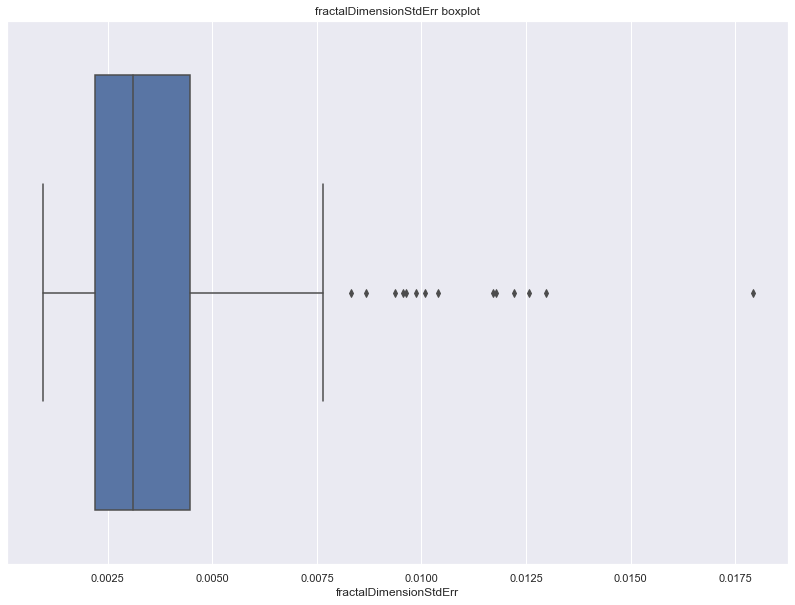

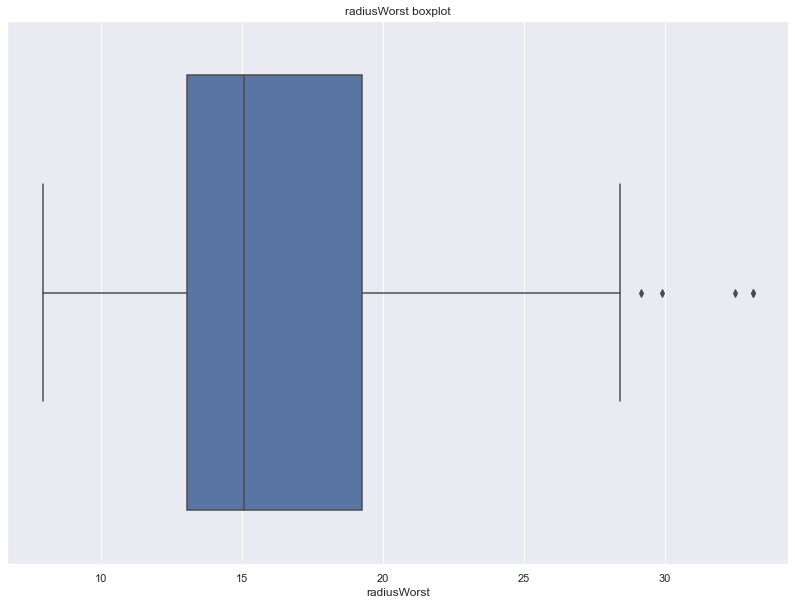

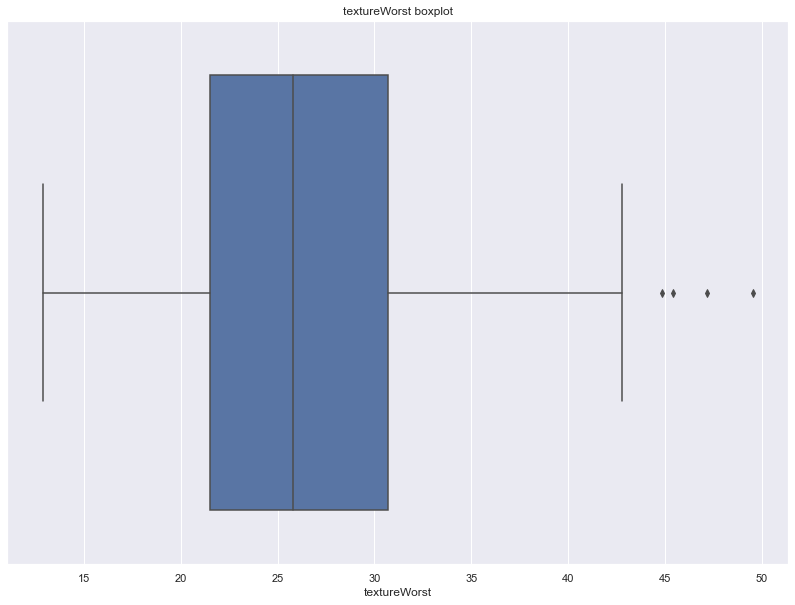

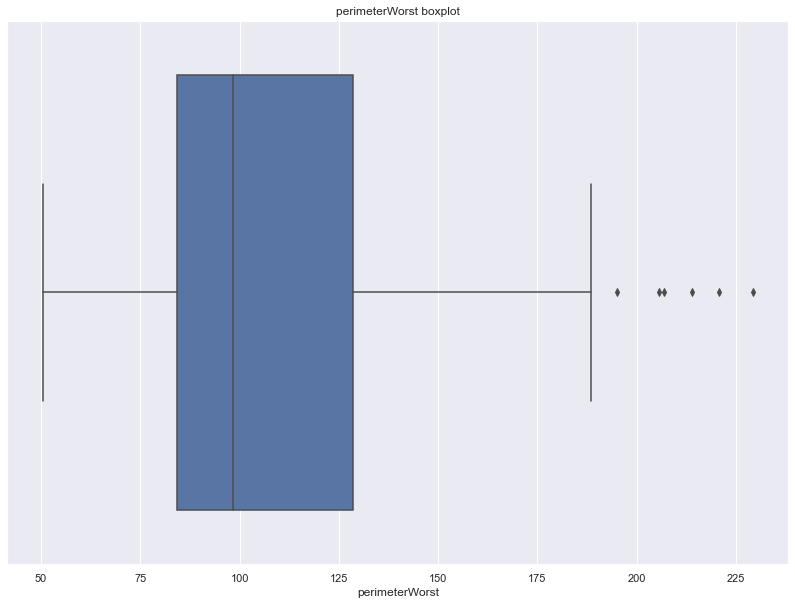

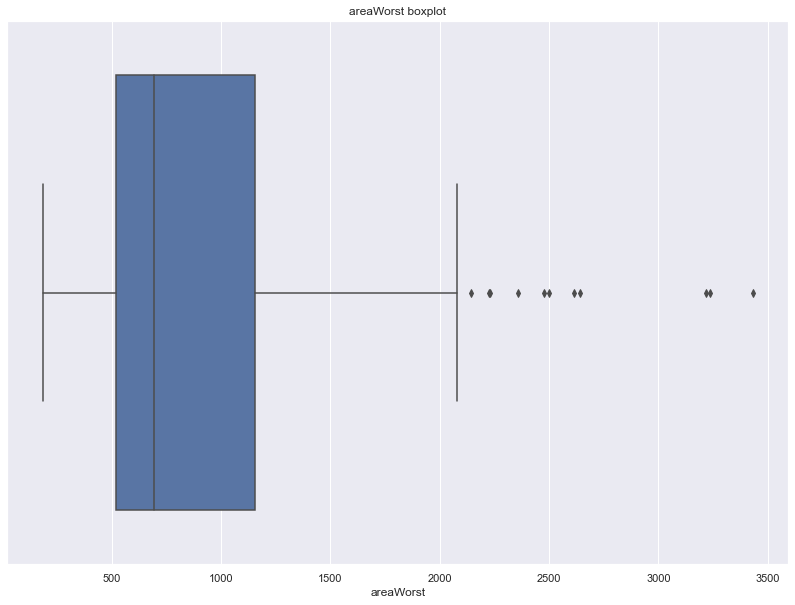

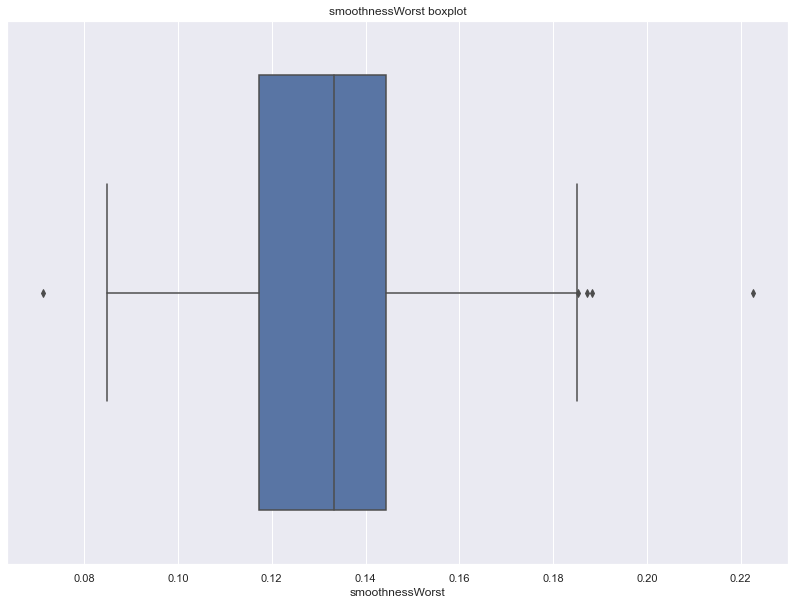

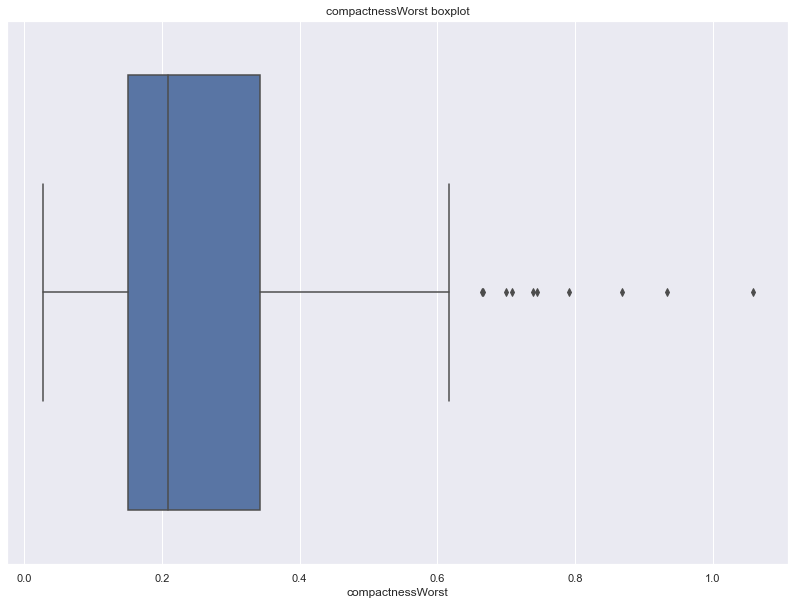

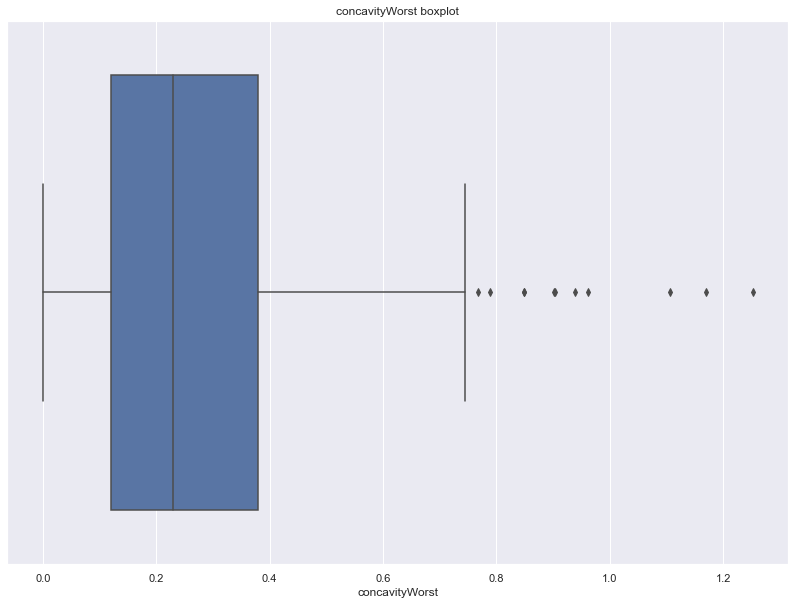

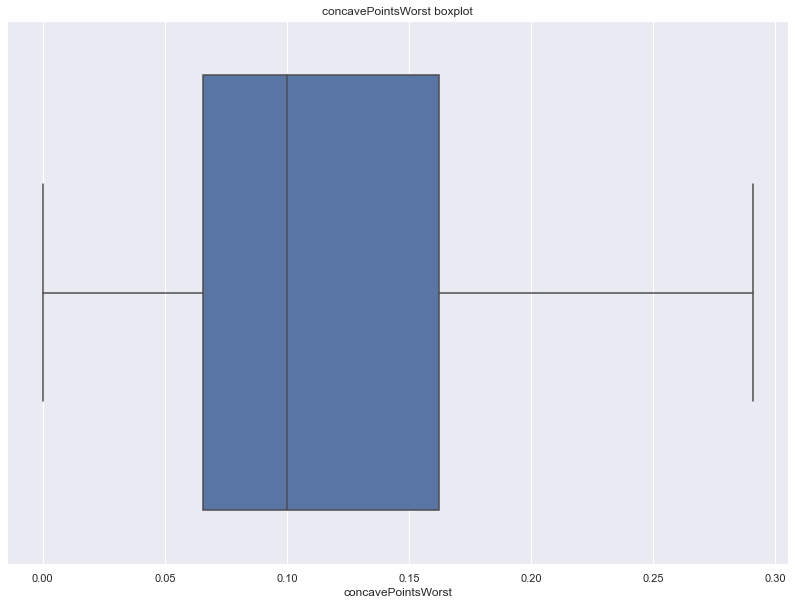

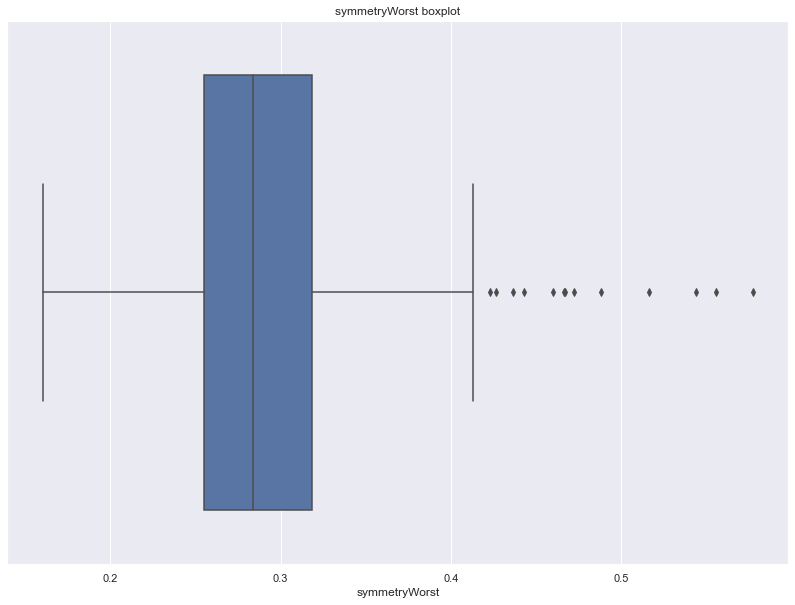

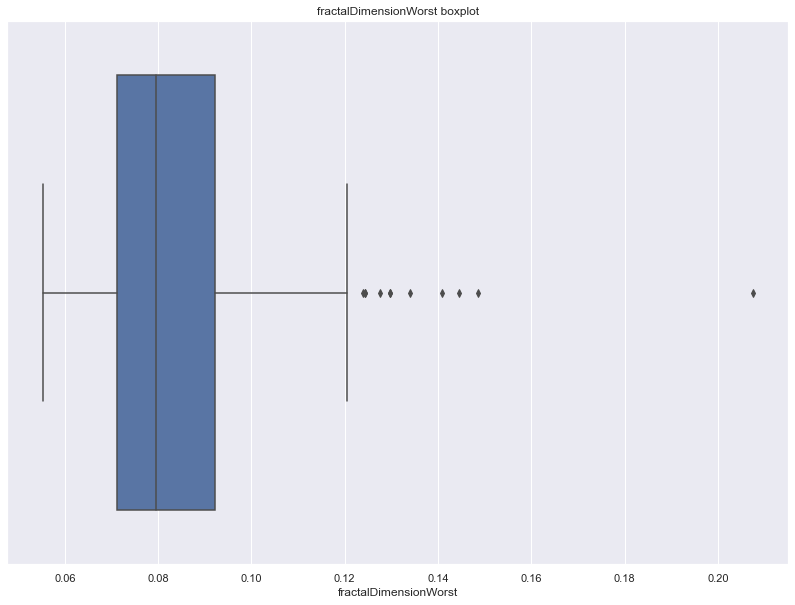

In [12]:
# boxplots of the attributes to see the distribution and outliers

for i, col in enumerate(df.columns[2:]):
    plt.figure(i)
    plt.title(col+" boxplot")
    sns.boxplot(x=df[col])

### 1.3. Outliers
In almost all of the attributes, we see from the boxplot that there are quite a few instances outside the normal range. As this is a very small data set, we are not sure how good it will be if we start removing the outliers. We will try to create a model with and without outliers, and see the difference in performance. The way we will remove the outliers will be using the RobustScaler before creating the model, that way it will remove all the instances that are outside the interquantile range.

## 2. Preprocessing

### 2.1. Train/test split
As we've mentioned in the beginning, the data set is already pre-split because of the competition, so we will use that split which is 50/50, and not 70/30 like we've decided in our experiment design.

In [13]:
# split into train/test
df = pd.read_csv("data/breast-cancer-diagnostic.shuf.lrn.csv")

X = df.drop(columns=['ID', 'class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2.2. Clean missing values
There are no missing values.

### 2.3. Remove outliers
We will try removing the outliers by using a RobustScaler(), which essentially removes all the instances that are outside the interquantile range. That is under 25% and over 75% of the variable distribution. We think that will remove a lot of the data instances, but we will see. Another option will be to leave outliers in the data.

### 2.4. Scaling
We will try multiple scalers like StandardScaler, MinMaxScaler and RobustScaler.  
Standard Scaler scales the data according to the normal distribution with mean 0.  
MinMaxScaler scales the data in the range of 0,1 or -1,1 depending on the data.  
And RobustScaler removes the outliers by only choosing the data in the interquantile range.

### 2.5. Encoding
We do not have any variables that need encoding in this data set. We only have the target variable as true/false, but that is already in a binary format so we do not need to convert it to 1/0.

### 2.6. PCA
PCA probably won't be of help to us in this data set. But we will give it a try.

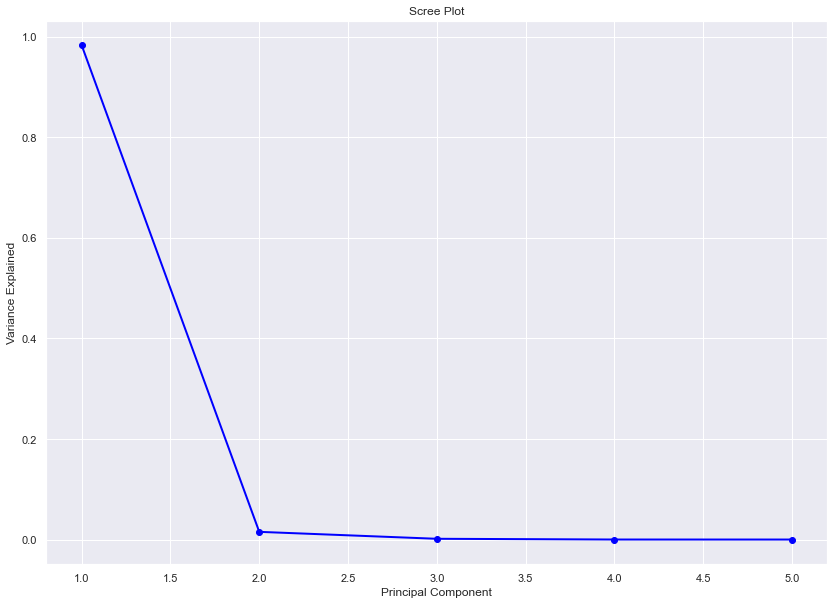

In [14]:
n_comp = 5

pca = PCA(n_components=n_comp)

pca.fit(X_train)

pc_values = np.arange(pca.n_components_) + 1

plt.plot(pc_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## 3. Model development

### 3.1. K-nearest neighbors

In [15]:
knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15]
}

# funtion to calculate distance between points

knn_search = RandomizedSearchCV(knn, knn_params, n_iter=7, scoring='accuracy', n_jobs=-1, cv=5)
knn_result = knn_search.fit(X_train, y_train)

In [16]:
print('Best Score: %s' % knn_result.best_score_)
print('Best Hyperparameters: %s' % knn_result.best_params_)

Best Score: 0.923974358974359
Best Hyperparameters: {'n_neighbors': 3}


In [17]:
y_pred = knn_search.predict(X_test)

print("Accurracy: ", f1_score(y_test, y_pred))

Accurracy:  0.9275362318840579


## 3.2. Random forest

In [18]:
rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [100, 125, 150, 175, 200, 250, 300]
}

rf_search = RandomizedSearchCV(rf, rf_params, n_iter=7, scoring='accuracy', n_jobs=-1, cv=5)
rf_result = rf_search.fit(X_train, y_train)

In [19]:
print('Best Score: %s' % rf_result.best_score_)
print('Best Hyperparameters: %s' % rf_result.best_params_)

Best Score: 0.9444871794871796
Best Hyperparameters: {'n_estimators': 250}


In [20]:
y_pred = rf_search.predict(X_test)

print("Accurracy: ", f1_score(y_test, y_pred))

Accurracy:  0.9117647058823529


In [21]:
# creating the rf model, to plot the importance of attributes
df_train = pd.read_csv("data/breast-cancer-diagnostic.shuf.lrn.csv")
df_test = pd.read_csv("data/breast-cancer-diagnostic.shuf.tes.csv")

X = df_train.drop(columns=['ID', 'class'])
y = df_train['class']

model = RandomForestClassifier(n_estimators=200)

model.fit(X, y)

RandomForestClassifier(n_estimators=200)

Text(0.5, 1.0, 'Importance of attributes in RF Classifier')

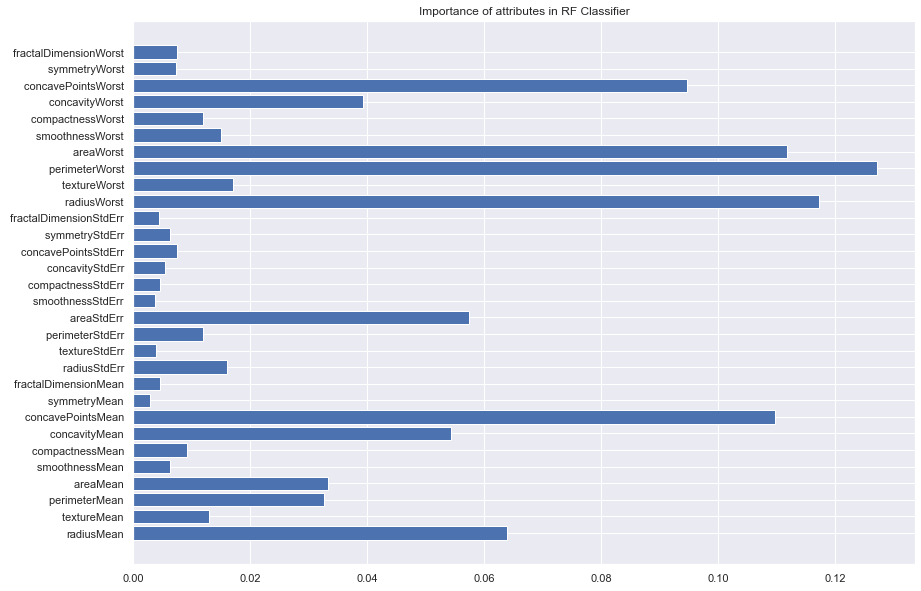

In [22]:
plt.barh(X_train.columns, model.feature_importances_)
plt.title("Importance of attributes in RF Classifier")

## 3.3. Multiple layer perceptron

In [23]:
mlp = MLPClassifier()

mlp_params = {
    'hidden_layer_sizes': [(400, 200), (300, 150), (200, 100), (400), (300), (200), (100)],
    'alpha': [0.0001, 0.0002, 0.0003],
    'learning_rate_init': [0.001, 0.002, 0.003],
    'max_iter': [500],
    'activation' : ['relu', 'tanh', 'identity', 'logistic'],
    'solver': ['adam', 'lbfgs']
}

mlp_search = RandomizedSearchCV(mlp, mlp_params, n_iter=15, scoring='accuracy', n_jobs=-1, cv=5)
mlp_result = mlp_search.fit(X_train, y_train)

In [24]:
print('Best Score: %s' % mlp_result.best_score_)
print('Best Hyperparameters: %s' % mlp_result.best_params_)

Best Score: 0.9491025641025642
Best Hyperparameters: {'solver': 'lbfgs', 'max_iter': 500, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (400, 200), 'alpha': 0.0001, 'activation': 'identity'}


In [25]:
y_pred = mlp_search.predict(X_test)

print("Accurracy: ", f1_score(y_test, y_pred))

Accurracy:  0.9444444444444445


## Model comparison

In [26]:
X = df_train.drop(columns=['ID', 'class'])
y = df_train['class']

cols = ["algorithm", "scaler", "val", "accuracy", "precision", "recall", "f1", "elapsed_time (sec)"]
results = pd.DataFrame(columns = cols)

classifiers = [
    KNeighborsClassifier(n_neighbors=3),
    RandomForestClassifier(n_estimators=200),
    MLPClassifier(hidden_layer_sizes=(100),
                  solver='adam',
                  activation='tanh',
                  alpha=0.0003,
                  max_iter=500,
                  learning_rate_init=0.002)
]

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler(),
    PCA(n_components=2),
    PCA(n_components=3),
    None
]

validation = ['cv', 'holdout']

for classifier in classifiers:
    for scaler in scalers:
        for validation_method in validation:
            steps = [
                ('scaler', scaler),
                ('clf', classifier)
            ]
            
            pipeline = Pipeline(steps)
            algorithm = classifier
            
            if validation_method == 'holdout':
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

                # --------------------------------
                st = time.time()
                # ------------
                pipeline.fit(X_train, y_train)   
                # ------------
                et = time.time()
                # --------------------------------

                y_pred = pipeline.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
                recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
                f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
                elapsed_time = et - st

                new_row = pd.DataFrame({
                    "algorithm": str(algorithm),
                    "scaler": str(scaler),
                    "val": 'holdout',
                    "accuracy": accuracy,
                    "precision":precision,
                    "recall":recall,
                    "f1": f1,
                    "elapsed_time (sec)": elapsed_time}, index=[0])

                results = pd.concat([new_row, results.loc[:]]).reset_index(drop=True)
                
            elif validation_method == 'cv':
                
                # --------------------------------
                st = time.time()
                # ------------
                accuracy_scores = cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")
                # ------------
                et = time.time()
                # --------------------------------
                
                elapsed_time = et - st
                
                precision_scores = cross_val_score(pipeline, X, y, cv=5, scoring="precision_macro")
                recall_scores = cross_val_score(pipeline, X, y, cv=5, scoring="recall_macro")
                f1_scores = cross_val_score(pipeline, X, y, cv=5, scoring="f1_macro")
                
                new_row = pd.DataFrame({
                    "algorithm": str(algorithm),
                    "scaler": str(scaler),
                    "val": 'cv',
                    "accuracy": accuracy_scores.mean(),
                    "precision":precision_scores.mean(),
                    "recall":recall_scores.mean(),
                    "f1": f1_scores.mean(),
                    "elapsed_time (sec)": elapsed_time}, index=[0])
                
                results = pd.concat([new_row, results.loc[:]]).reset_index(drop=True)

In [27]:
results.sort_values(by="f1", ascending=False)

,algorithm,scaler,val,accuracy,precision,recall,f1,elapsed_time (sec)
6,"MLPClassifier(activation='tanh', alpha=0.0003,...",RobustScaler(),holdout,0.988372,0.990385,0.985714,0.987899,0.500807
10,"MLPClassifier(activation='tanh', alpha=0.0003,...",StandardScaler(),holdout,0.976744,0.981132,0.971429,0.975679,0.597551
16,RandomForestClassifier(n_estimators=200),PCA(n_components=2),holdout,0.965116,0.966063,0.961625,0.963698,0.250757
8,"MLPClassifier(activation='tanh', alpha=0.0003,...",MinMaxScaler(),holdout,0.965116,0.972222,0.957143,0.963326,0.609372
11,"MLPClassifier(activation='tanh', alpha=0.0003,...",StandardScaler(),cv,0.954386,0.964299,0.950303,0.962246,3.026497
9,"MLPClassifier(activation='tanh', alpha=0.0003,...",MinMaxScaler(),cv,0.964912,0.968766,0.957706,0.958620,3.885478
0,"MLPClassifier(activation='tanh', alpha=0.0003,...",None,holdout,0.953488,0.949255,0.956303,0.952222,0.609568
2,"MLPClassifier(activation='tanh', alpha=0.0003,...",PCA(n_components=3),holdout,0.953488,0.951821,0.951821,0.951821,0.484369
34,KNeighborsClassifier(n_neighbors=3),StandardScaler(),holdout,0.953488,0.956547,0.947339,0.951357,0.000000
30,KNeighborsClassifier(n_neighbors=3),RobustScaler(),holdout,0.953488,0.956547,0.947339,0.951357,0.015625


## Kaggle Challenge Models

### Model 1. - MLP + RobustScaler

In [28]:
df_train = pd.read_csv("data/breast-cancer-diagnostic.shuf.lrn.csv")
df_test = pd.read_csv("data/breast-cancer-diagnostic.shuf.tes.csv")

X = df_train.drop(columns=['ID', 'class'])
y = df_train['class']

scaler = RobustScaler().fit(X)
X = scaler.transform(X)

model = MLPClassifier(hidden_layer_sizes=(100),
                  solver='adam',
                  activation='tanh',
                  alpha=0.0003,
                  max_iter=500,
                  learning_rate_init=0.002)

model.fit(X, y)

train_id = df_train['ID']
test_id = df_test['ID']

test_data = df_test.drop(columns=['ID'])
test_data = scaler.transform(test_data)

test_pred = model.predict(test_data)

sol = {
    'ID':np.array(test_id),
    'class':test_pred
}

df = pd.DataFrame(sol)

df.to_csv('kaggle-breast-cancer.csv', index=False)

### Model 2. - Knn (3) + RobustScaler

This was the best model in for the competition with an f1-score of 0.96296.

In [29]:
df_train = pd.read_csv("data/breast-cancer-diagnostic.shuf.lrn.csv")
df_test = pd.read_csv("data/breast-cancer-diagnostic.shuf.tes.csv")

X = df_train.drop(columns=['ID', 'class'])
y = df_train['class']

scaler = RobustScaler().fit(X)
X = scaler.transform(X)

model = KNeighborsClassifier(n_neighbors=3)

model.fit(X, y)

train_id = df_train['ID']
test_id = df_test['ID']

test_data = df_test.drop(columns=['ID'])
test_data = scaler.transform(test_data)

test_pred = model.predict(test_data)

sol = {
    'ID':np.array(test_id),
    'class':test_pred
}

df = pd.DataFrame(sol)

df.to_csv('kaggle-breast-cancer.csv', index=False)

### Model 3. - Rf + PCA(2)

In [30]:
df_train = pd.read_csv("data/breast-cancer-diagnostic.shuf.lrn.csv")
df_test = pd.read_csv("data/breast-cancer-diagnostic.shuf.tes.csv")

X = df_train.drop(columns=['ID', 'class'])
y = df_train['class']

scaler =  PCA(n_components=2).fit(X)
X = scaler.transform(X)

model = RandomForestClassifier(n_estimators=200)

model.fit(X, y)

train_id = df_train['ID']
test_id = df_test['ID']

test_data = df_test.drop(columns=['ID'])
test_data = scaler.transform(test_data)

test_pred = model.predict(test_data)

sol = {
    'ID':np.array(test_id),
    'class':test_pred
}

df = pd.DataFrame(sol)

df.to_csv('kaggle-breast-cancer.csv', index=False)

### Model 4. - Knn (3) + StandardScaler

In [31]:
df_train = pd.read_csv("data/breast-cancer-diagnostic.shuf.lrn.csv")
df_test = pd.read_csv("data/breast-cancer-diagnostic.shuf.tes.csv")

X = df_train.drop(columns=['ID', 'class'])
y = df_train['class']

scaler =  StandardScaler().fit(X)
X = scaler.transform(X)

model = KNeighborsClassifier(n_neighbors=3)

model.fit(X, y)

train_id = df_train['ID']
test_id = df_test['ID']

test_data = df_test.drop(columns=['ID'])
test_data = scaler.transform(test_data)

test_pred = model.predict(test_data)

sol = {
    'ID':np.array(test_id),
    'class':test_pred
}

df = pd.DataFrame(sol)

df.to_csv('kaggle-breast-cancer.csv', index=False)

### Model 5. - MLP + MinMaxScaler

In [32]:
df_train = pd.read_csv("data/breast-cancer-diagnostic.shuf.lrn.csv")
df_test = pd.read_csv("data/breast-cancer-diagnostic.shuf.tes.csv")

X = df_train.drop(columns=['ID', 'class'])
y = df_train['class']

scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

model = MLPClassifier(hidden_layer_sizes=(100),
                  solver='adam',
                  activation='tanh',
                  alpha=0.0003,
                  max_iter=500,
                  learning_rate_init=0.002)

model.fit(X, y)

train_id = df_train['ID']
test_id = df_test['ID']

test_data = df_test.drop(columns=['ID'])
test_data = scaler.transform(test_data)

test_pred = model.predict(test_data)

sol = {
    'ID':np.array(test_id),
    'class':test_pred
}

df = pd.DataFrame(sol)

df.to_csv('kaggle-breast-cancer.csv', index=False)

# 0.94545

### Model 6. - XGBoost default test

In [33]:
import xgboost as xgb

df_train = pd.read_csv("data/breast-cancer-diagnostic.shuf.lrn.csv")
df_test = pd.read_csv("data/breast-cancer-diagnostic.shuf.tes.csv")

X = df_train.drop(columns=['ID', 'class'])
y = df_train['class']

xgb_model = xgb.XGBClassifier(objective='binary:logistic')

xgb_model.fit(X, y)

test_data = df_test.drop(columns=['ID'])

test_id = df_test['ID']
test_pred = xgb_model.predict(test_data)

lista = list()
for x in test_pred:
    lista.append(True if x == 1 else False)
    
test_pred = np.array(lista)

sol = {
    'ID':np.array(test_id),
    'class':test_pred
}

df.to_csv('kaggle-breast-cancer.csv', index=False)

# 0.92

## 4. Results discussion

We can see throughout our models that the worst performing scaler by far is the PCA, where the models used in combination with it ranked at the bottom of our metrics table. But we can also see the power of MLP, where it is the only one in combination with PCA that provided great results. KNN (7) performed the 6th best in combination without any scaling, which seems odd considering we have always been thought that scaling is essential when using KNN. The difference in size between attributes is quite high. RF Classifier performed much worse than expected, I'm not sure why.